# Import Library

In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, f1_score

import config
from data_preprocessing import load_data, create_text_vectorizer, compute_f1_score
from model import create_lstm_model 
from train import train_and_evaluate_lstm_model, plot_training_history 

# Atur seed untuk reproduksibilitas
np.random.seed(config.RANDOM_SEED)
tf.random.set_seed(config.RANDOM_SEED)

pd.set_option('display.max_colwidth', 100) 
pd.set_option('display.width', 1000)

# 1. Data Preprocessing

Memuat dan memproses dataset NusaX-Sentiment untuk analisis sentimen dalam Bahasa Indonesia.

Dataset sizes: Train=500, Valid=100, Test=400
Kelas dalam dataset: ['negative', 'neutral', 'positive'] -> {'negative': 0, 'neutral': 1, 'positive': 2}
Jumlah kelas: 3
Distribusi label train: [192 119 189]
Distribusi label valid: [38 24 38]
Distribusi label test: [153  96 151]


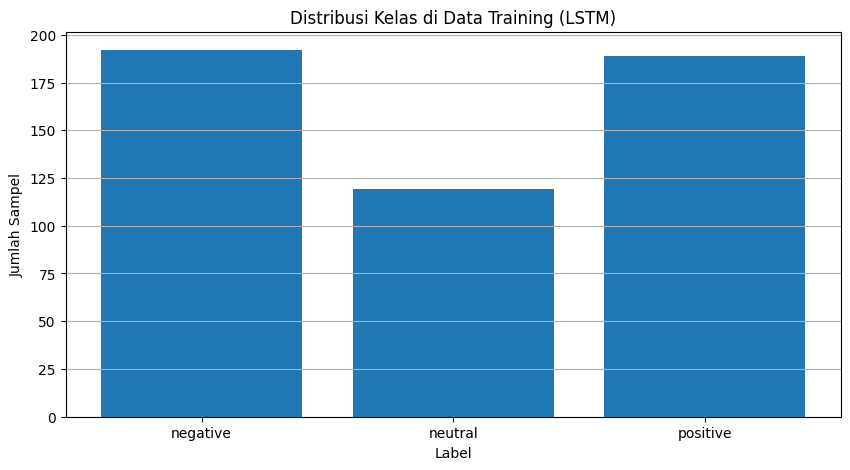


Ukuran Vocabulary (dari TextVectorization): 2836
Contoh beberapa token dari vocabulary: ['jangan', 'ingin', 'dalam', 'cepat', 'aku', '1', 'sehingga', 'rumah', 'luar', 'indonesia']

Contoh data training:
Teks: Nikmati cicilan 0% hingga 12 bulan untuk pemesanan tiket pesawat air asia dengan kartu kredit bni!... | Label Asli: neutral | Label Numerik: 1
Teks Vektorisasi (awal): [1758 1080 1145  196 2834  198   11  607  177  847  283  547    7  507
  496]...
Teks: Kue-kue yang disajikan bikin saya bernostalgia. Semuanya tipikal kue zaman dulu, baik dari penampila... | Label Asli: positive | Label Numerik: 2
Teks Vektorisasi (awal): [2042    2  126  139    6 2625  456 1224  493  221  334   75   21  862
  266]...
Teks: Ibu pernah bekerja di grab indonesia... | Label Asli: neutral | Label Numerik: 1
Teks Vektorisasi (awal): [ 404  155  541    3 1020  109    0    0    0    0    0    0    0    0
    0]...


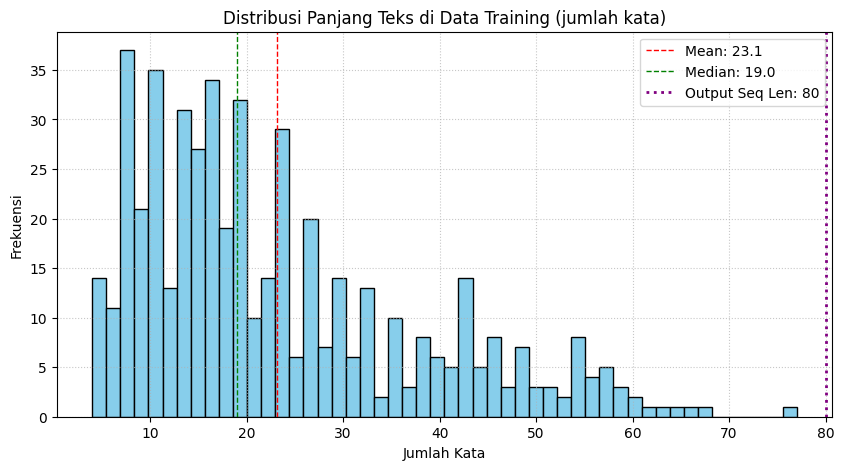

Panjang rata-rata (kata): 23.1
Panjang median (kata): 19.0
Panjang maksimum (kata): 77
Panjang teks yang dipilih untuk sekuens (OUTPUT_SEQ_LEN): 80


In [2]:
# Muat data
(train_texts, train_labels), (valid_texts, valid_labels), (test_texts, test_labels), label_mapping, num_classes = load_data()

# Tampilkan informasi data
print(f"Dataset sizes: Train={len(train_texts)}, Valid={len(valid_texts)}, Test={len(test_texts)}")
print(f"Kelas dalam dataset: {list(label_mapping.keys())} -> {label_mapping}")
print(f"Jumlah kelas: {num_classes}")
print(f"Distribusi label train: {np.bincount(train_labels)}")
print(f"Distribusi label valid: {np.bincount(valid_labels)}")
print(f"Distribusi label test: {np.bincount(test_labels)}")

# Visualisasi distribusi kelas pada data training
plt.figure(figsize=(10, 5))
class_counts_train = np.bincount(train_labels)
plt.bar(list(label_mapping.keys()), class_counts_train)
plt.title('Distribusi Kelas di Data Training (LSTM)')
plt.xlabel('Label')
plt.ylabel('Jumlah Sampel')
plt.grid(axis='y')
plt.show()

# Buat text vectorizer menggunakan data training
vectorizer, vocab, vocab_size = create_text_vectorizer(
    train_texts, 
    max_tokens=config.MAX_TOKENS, 
    output_sequence_length=config.OUTPUT_SEQ_LEN
)
print(f"\nUkuran Vocabulary (dari TextVectorization): {vocab_size}")
print(f"Contoh beberapa token dari vocabulary: {vocab[100:110]}")

# Tampilkan beberapa contoh teks dan label yang sudah di-map ke integer
print("\nContoh data training:")
for i in range(3):
    sentiment = list(label_mapping.keys())[train_labels[i]]
    print(f"Teks: {train_texts[i][:100]}... | Label Asli: {sentiment} | Label Numerik: {train_labels[i]}")
    vectorized_text = vectorizer([train_texts[i]])
    print(f"Teks Vektorisasi (awal): {vectorized_text.numpy()[0, :15]}...")

# Visualisasikan panjang teks (jumlah kata)
text_lengths_train = [len(text.split()) for text in train_texts]
plt.figure(figsize=(10, 5))
plt.hist(text_lengths_train, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribusi Panjang Teks di Data Training (jumlah kata)')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.axvline(np.mean(text_lengths_train), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(text_lengths_train):.1f}')
plt.axvline(np.median(text_lengths_train), color='green', linestyle='dashed', linewidth=1, label=f'Median: {np.median(text_lengths_train):.1f}')
plt.axvline(config.OUTPUT_SEQ_LEN, color='purple', linestyle='dotted', linewidth=2, label=f'Output Seq Len: {config.OUTPUT_SEQ_LEN}')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

print(f"Panjang rata-rata (kata): {np.mean(text_lengths_train):.1f}")
print(f"Panjang median (kata): {np.median(text_lengths_train):.1f}")
print(f"Panjang maksimum (kata): {np.max(text_lengths_train)}")
print(f"Panjang teks yang dipilih untuk sekuens (OUTPUT_SEQ_LEN): {config.OUTPUT_SEQ_LEN}")

# 2 Model LSTM Dasar

Di bagian ini kita akan membuat dan melatih model LSTM dasar untuk klasifikasi sentimen.

In [3]:
# Cek parameter default untuk LSTM dari config.py
print("Parameter model LSTM default dari config.py:")
print(f"- Embedding dimension: {config.EMBEDDING_DIM}")
print(f"- LSTM units: {config.LSTM_UNITS}")
print(f"- Number of LSTM layers: {config.NUM_LSTM_LAYERS}")
print(f"- Bidirectional LSTM: {config.BIDIRECTIONAL_LSTM}")
print(f"- Dropout rate (setelah LSTM/Dense): {config.DROPOUT_RATE}")
print(f"- Embedding Dropout rate (SpatialDropout1D): {config.EMBEDDING_DROPOUT}")
print(f"- Recurrent Dropout rate (dalam LSTM cell): {config.RECURRENT_DROPOUT_LSTM}")
print(f"- L2 Regularization: {config.L2_REG}")
print(f"- Learning Rate: {config.LEARNING_RATE}")

print(f"\nParameter training dari config.py:")
print(f"- Batch size: {config.BATCH_SIZE}")
print(f"- Max epochs: {config.EPOCHS}")
print(f"- Early Stopping Patience: {config.ES_PATIENCE}")
print(f"- ReduceLROnPlateau Factor: {config.LR_FACTOR}")
print(f"- ReduceLROnPlateau Patience: {config.LR_PATIENCE}")
print(f"- Minimum Learning Rate: {config.MIN_LR}")

# Parameter data preprocessing dari config.py
print(f"\nParameter data preprocessing dari config.py:")
print(f"- Max tokens (vocabulary size): {config.MAX_TOKENS}")
print(f"- Output sequence length: {config.OUTPUT_SEQ_LEN}")

Parameter model LSTM default dari config.py:
- Embedding dimension: 128
- LSTM units: 64
- Number of LSTM layers: 2
- Bidirectional LSTM: True
- Dropout rate (setelah LSTM/Dense): 0.2
- Embedding Dropout rate (SpatialDropout1D): 0.1
- Recurrent Dropout rate (dalam LSTM cell): 0.05
- L2 Regularization: 0.0001
- Learning Rate: 0.001

Parameter training dari config.py:
- Batch size: 32
- Max epochs: 24
- Early Stopping Patience: 6
- ReduceLROnPlateau Factor: 0.7
- ReduceLROnPlateau Patience: 3
- Minimum Learning Rate: 1e-05

Parameter data preprocessing dari config.py:
- Max tokens (vocabulary size): 8000
- Output sequence length: 80



Memulai pelatihan model LSTM baseline...

--- Training LSTM Model: baseline_lstm_model ---
Config: Layers=2, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,027 (2.14 MB)

 Trainable params: 561,027 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3119 - loss: 1.2410
Epoch 1: val_loss improved from inf to 1.17645, saving model to checkpoints/baseline_lstm_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 172ms/step - accuracy: 0.3177 - loss: 1.2392 - val_accuracy: 0.4200 - val_loss: 1.1764 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5119 - loss: 1.0414
Epoch 2: val_loss improved from 1.17645 to 1.05606, saving model to checkpoints/baseline_lstm_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 0.5150 - loss: 1.0391 - val_accuracy: 0.5100 - val_loss: 1.0561 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.6462 - loss: 0.8209
Epoch 3: val_loss improved from 1.05606 to 0.92032, saving model to checkpoints/baseline_lstm_model.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.6488 - loss: 0.8188 - val_accuracy: 0.6200 - 

Test Loss: 0.8023
Test Accuracy: 0.7350
Test Macro F1: 0.7232

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.68      0.76      0.72       153
     neutral       0.67      0.60      0.64        96
    positive       0.84      0.79      0.82       151

    accuracy                           0.73       400
   macro avg       0.73      0.72      0.72       400
weighted avg       0.74      0.73      0.74       400

Model lengkap disimpan di: models/baseline_lstm_model_full_model.keras
Vectorizer disimpan di: models/baseline_lstm_model_vectorizer.keras


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


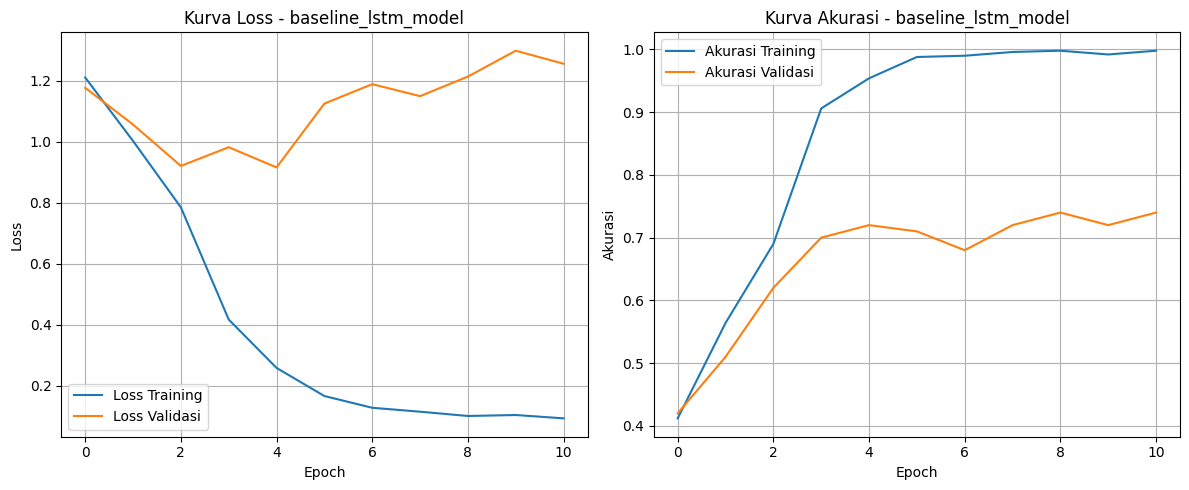


Metrik evaluasi model LSTM baseline:
- test_loss: 0.8023
- test_accuracy: 0.7350
- test_f1: 0.7232
- training_time: 30.4654


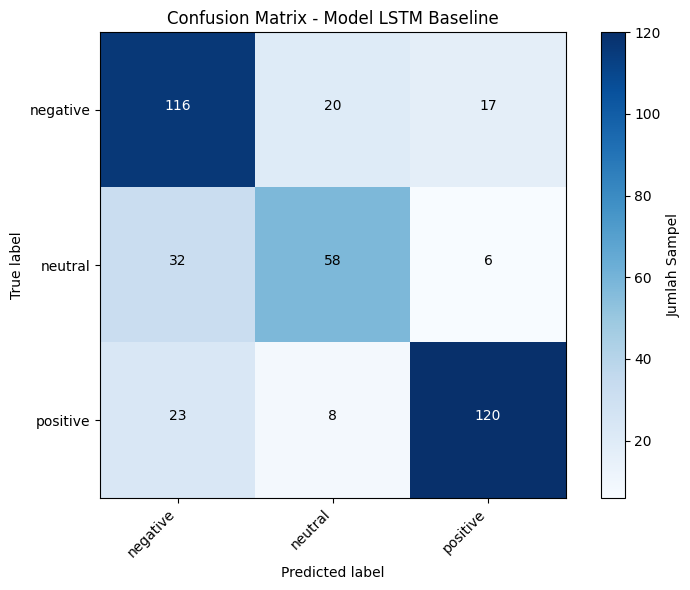

In [4]:
# Buat folder untuk menyimpan hasil
os.makedirs("models", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

# Latih model LSTM baseline menggunakan parameter default dari config.py
print("\nMemulai pelatihan model LSTM baseline...")
model_baseline_lstm, history_baseline_lstm, preds_baseline_lstm, labels_true_baseline_lstm, vectorizer_baseline_lstm, metrics_baseline_lstm = train_and_evaluate_lstm_model(
    model_name="baseline_lstm_model" 
)

# Plot kurva training untuk model baseline
plot_training_history(history_baseline_lstm, "baseline_lstm_model") 

# Tampilkan metrik evaluasi
print("\nMetrik evaluasi model LSTM baseline:")
for name, value in metrics_baseline_lstm.items():
    if isinstance(value, float):
        print(f"- {name}: {value:.4f}")
    else:
        print(f"- {name}: {value}")


# Visualisasi Confusion Matrix untuk model baseline
pred_classes_baseline_lstm = np.argmax(preds_baseline_lstm, axis=1)
cm_baseline_lstm = confusion_matrix(labels_true_baseline_lstm, pred_classes_baseline_lstm)

plt.figure(figsize=(8, 6))
plt.imshow(cm_baseline_lstm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Model LSTM Baseline')
plt.colorbar(label='Jumlah Sampel')

tick_marks = np.arange(len(list(label_mapping.keys())))
plt.xticks(tick_marks, list(label_mapping.keys()), rotation=45, ha="right")
plt.yticks(tick_marks, list(label_mapping.keys()))

# Tambahkan teks nilai ke confusion matrix
thresh = cm_baseline_lstm.max() / 2.
for i in range(cm_baseline_lstm.shape[0]):
    for j in range(cm_baseline_lstm.shape[1]):
        plt.text(j, i, format(cm_baseline_lstm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_baseline_lstm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# 3. Eksperimen Variasi Parameter

Di bagian ini kita melakukan eksperimen untuk menguji pengaruh:
1. Jumlah layer LSTM
2. Jumlah unit/cell LSTM per layer
3. Arah LSTM (unidirectional vs bidirectional)

In [5]:
# Direktori untuk menyimpan hasil eksperimen LSTM
RESULTS_DIR_LSTM = "experiment_results_lstm"
os.makedirs(RESULTS_DIR_LSTM, exist_ok=True)
print(f"Hasil eksperimen LSTM akan disimpan di: {RESULTS_DIR_LSTM}")

# Definisikan variasi parameter yang akan diuji untuk LSTM
LSTM_LAYERS_VARIATIONS = [1, 2, 3]  # Jumlah layer LSTM
LSTM_UNITS_VARIATIONS = [32, 64, 128] # Jumlah unit per layer LSTM 
BIDIRECTIONAL_LSTM_VARIATIONS = [False, True]  # Unidirectional vs Bidirectional LSTM

Hasil eksperimen LSTM akan disimpan di: experiment_results_lstm


## 3.1 Eksperimen Jumlah Layer
3 variasi jumlah layer LSTM: 1, 2, dan 3 layer.

In [6]:
def run_lstm_layer_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah layer LSTM"""
    print("\n" + "="*60)
    print("EKSPERIMEN LSTM: VARIASI JUMLAH LAYER LSTM")
    print("="*60)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah layer LSTM
    for num_layers in LSTM_LAYERS_VARIATIONS:
        model_name = f"lstm_layers_{num_layers}"
        print(f"\n--- Menguji model LSTM dengan {num_layers} layer ---")
        
        _, history, _, _, _, metrics = train_and_evaluate_lstm_model(
            num_lstm_layers=num_layers, # Override jumlah layer LSTM
            model_name=model_name
        )
        
        # Simpan hasilnya
        results.append({
            'num_lstm_layers': num_layers,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': metrics['training_time']
        })
        
        # Simpan history untuk plot
        histories[num_layers] = history
    
    # Konversi ke DataFrame untuk analisis lebih mudah
    results_df = pd.DataFrame(results)
    
    # Simpan hasil ke CSV
    csv_path = f"{RESULTS_DIR_LSTM}/lstm_layer_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\nHasil eksperimen jumlah layer LSTM disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah layer LSTM
layer_results_df_lstm, layer_histories_lstm = run_lstm_layer_count_experiment()


EKSPERIMEN LSTM: VARIASI JUMLAH LAYER LSTM

--- Menguji model LSTM dengan 1 layer ---

--- Training LSTM Model: lstm_layers_1 ---
Config: Layers=1, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462,211 (1.76 MB)

 Trainable params: 462,211 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2700 - loss: 1.1862
Epoch 1: val_loss improved from inf to 1.14532, saving model to checkpoints/lstm_layers_1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.2763 - loss: 1.1853 - val_accuracy: 0.5500 - val_loss: 1.1453 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5539 - loss: 1.0706
Epoch 2: val_loss improved from 1.14532 to 1.04351, saving model to checkpoints/lstm_layers_1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.5542 - loss: 1.0687 - val_accuracy: 0.5000 - val_loss: 1.0435 - learning_rate: 0.0010
Epoch 3/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6125 - loss: 0.8815
Epoch 3: val_loss improved from 1.04351 to 1.01019, saving model to checkpoints/lstm_layers_1.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6120 - loss: 0.8801 - val_accuracy: 0.5200 - val_loss: 1.0102 - learni

Test Loss: 0.7381
Test Accuracy: 0.7400
Test Macro F1: 0.7319

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.65      0.81      0.72       153
     neutral       0.67      0.62      0.65        96
    positive       0.94      0.74      0.83       151

    accuracy                           0.74       400
   macro avg       0.75      0.73      0.73       400
weighted avg       0.76      0.74      0.74       400

Model lengkap disimpan di: models/lstm_layers_1_full_model.keras
Vectorizer disimpan di: models/lstm_layers_1_vectorizer.keras

--- Menguji model LSTM dengan 2 layer ---

--- Training LSTM Model: lstm_layers_2 ---
Config: Layers=2, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,027 (2.14 MB)

 Trainable params: 561,027 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3209 - loss: 1.2410
Epoch 1: val_loss improved from inf to 1.17559, saving model to checkpoints/lstm_layers_2.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - accuracy: 0.3255 - loss: 1.2395 - val_accuracy: 0.4500 - val_loss: 1.1756 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.5078 - loss: 1.0445
Epoch 2: val_loss improved from 1.17559 to 1.04656, saving model to checkpoints/lstm_layers_2.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.5107 - loss: 1.0420 - val_accuracy: 0.5300 - val_loss: 1.0466 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.6479 - loss: 0.8037
Epoch 3: val_loss improved from 1.04656 to 0.94868, saving model to checkpoints/lstm_layers_2.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - accuracy: 0.6498 - loss: 0.8025 - val_accuracy: 0.6100 - val_loss: 0.9487 -

Test Loss: 0.8151
Test Accuracy: 0.7375
Test Macro F1: 0.7188

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.66      0.78      0.72       153
     neutral       0.70      0.53      0.60        96
    positive       0.84      0.83      0.84       151

    accuracy                           0.74       400
   macro avg       0.74      0.71      0.72       400
weighted avg       0.74      0.74      0.73       400

Model lengkap disimpan di: models/lstm_layers_2_full_model.keras
Vectorizer disimpan di: models/lstm_layers_2_vectorizer.keras

--- Menguji model LSTM dengan 3 layer ---

--- Training LSTM Model: lstm_layers_3 ---
Config: Layers=3, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_3            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_3 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 659,843 (2.52 MB)

 Trainable params: 659,843 (2.52 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.2756 - loss: 1.2821
Epoch 1: val_loss improved from inf to 1.15228, saving model to checkpoints/lstm_layers_3.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 277ms/step - accuracy: 0.2819 - loss: 1.2784 - val_accuracy: 0.4800 - val_loss: 1.1523 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.5824 - loss: 1.0226
Epoch 2: val_loss improved from 1.15228 to 1.10496, saving model to checkpoints/lstm_layers_3.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - accuracy: 0.5828 - loss: 1.0223 - val_accuracy: 0.5300 - val_loss: 1.1050 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.7170 - loss: 0.8184
Epoch 3: val_loss improved from 1.10496 to 0.97359, saving model to checkpoints/lstm_layers_3.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.7177 - loss: 0.8165 - val_accuracy: 0.6300 - val_loss: 0.9736 -

Test Loss: 0.9325
Test Accuracy: 0.6425
Test Macro F1: 0.6451

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.56      0.65      0.60       153
     neutral       0.60      0.68      0.63        96
    positive       0.81      0.62      0.70       151

    accuracy                           0.64       400
   macro avg       0.66      0.65      0.65       400
weighted avg       0.66      0.64      0.65       400

Model lengkap disimpan di: models/lstm_layers_3_full_model.keras
Vectorizer disimpan di: models/lstm_layers_3_vectorizer.keras

Hasil eksperimen jumlah layer LSTM disimpan di experiment_results_lstm/lstm_layer_count_results.csv


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Layer LSTM:


,num_lstm_layers,accuracy,f1_score,loss,train_time
0,1,0.7400,0.731907,0.738052,13.655903
1,2,0.7375,0.718846,0.815071,30.071778
2,3,0.6425,0.645073,0.932463,40.421708


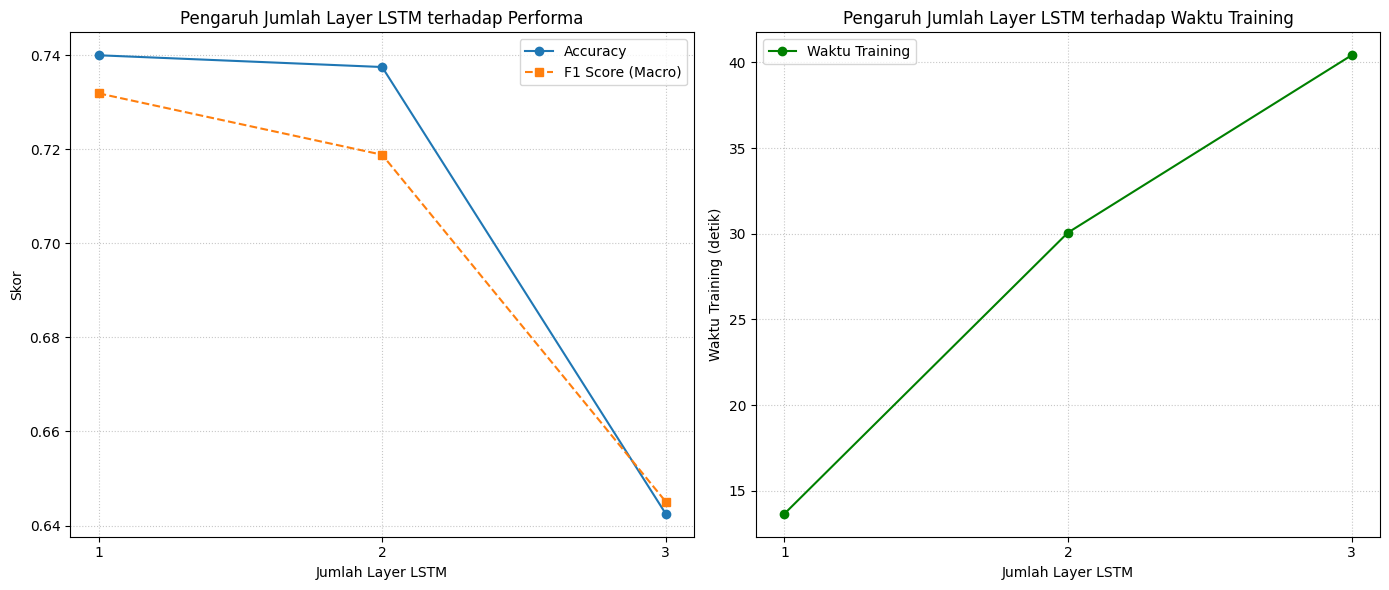

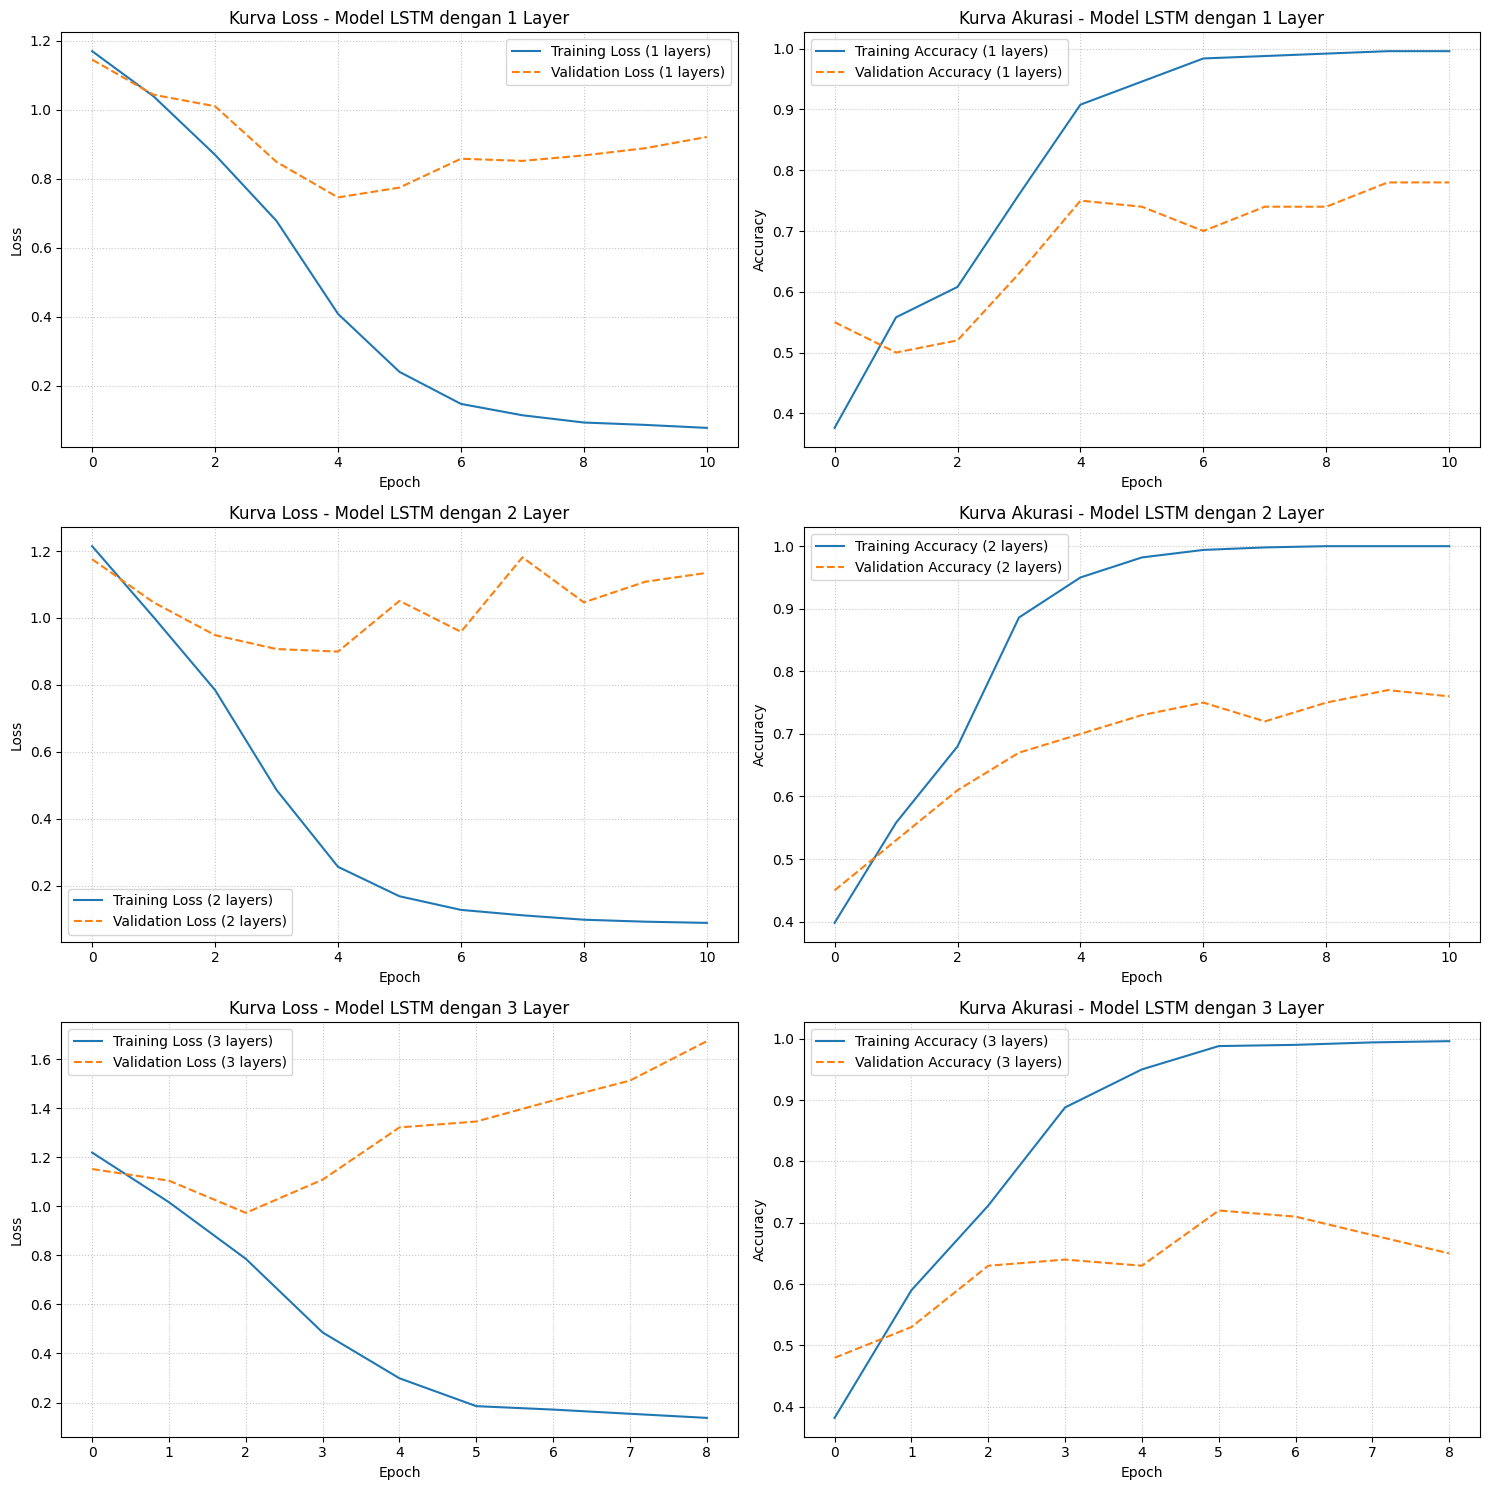

In [7]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Layer LSTM:")
display(layer_results_df_lstm)

# Visualisasikan pengaruh jumlah layer LSTM terhadap performa
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(layer_results_df_lstm['num_lstm_layers'], layer_results_df_lstm['accuracy'], 'o-', label='Accuracy')
plt.plot(layer_results_df_lstm['num_lstm_layers'], layer_results_df_lstm['f1_score'], 's--', label='F1 Score (Macro)')
plt.xlabel('Jumlah Layer LSTM')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Layer LSTM terhadap Performa')
plt.xticks(layer_results_df_lstm['num_lstm_layers']) # Pastikan semua nilai variasi ditampilkan
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(layer_results_df_lstm['num_lstm_layers'], layer_results_df_lstm['train_time'], 'o-', color='green', label='Waktu Training')
plt.xlabel('Jumlah Layer LSTM')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Layer LSTM terhadap Waktu Training')
plt.xticks(layer_results_df_lstm['num_lstm_layers'])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah layer LSTM
num_variations = len(LSTM_LAYERS_VARIATIONS)
plt.figure(figsize=(15, 5 * num_variations)) # Lebar, tinggi per subplot

for i, layers in enumerate(LSTM_LAYERS_VARIATIONS):
    history_data = layer_histories_lstm[layers].history
    
    # Plot Loss
    plt.subplot(num_variations, 2, 2*i + 1)
    plt.plot(history_data['loss'], label=f'Training Loss ({layers} layers)')
    plt.plot(history_data['val_loss'], '--', label=f'Validation Loss ({layers} layers)')
    plt.title(f'Kurva Loss - Model LSTM dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    
    # Plot Accuracy
    plt.subplot(num_variations, 2, 2*i + 2)
    plt.plot(history_data['accuracy'], label=f'Training Accuracy ({layers} layers)')
    plt.plot(history_data['val_accuracy'], '--', label=f'Validation Accuracy ({layers} layers)')
    plt.title(f'Kurva Akurasi - Model LSTM dengan {layers} Layer')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

## 3.2 Eksperimen Jumlah Unit LSTM
3 variasi jumlah unit per layer: 32, 64, dan 128 unit

In [8]:
def run_lstm_unit_count_experiment():
    """Jalankan eksperimen untuk menguji pengaruh jumlah unit LSTM per layer"""
    print("\n" + "="*60)
    print("EKSPERIMEN LSTM: VARIASI JUMLAH UNIT LSTM PER LAYER")
    print("="*60)
    
    results = []
    histories = {}
    
    # Uji untuk setiap jumlah unit LSTM
    for num_units in LSTM_UNITS_VARIATIONS:
        model_name = f"lstm_units_{num_units}"
        print(f"\n--- Menguji model LSTM dengan {num_units} unit per layer ---")
        
        _, history, _, _, _, metrics = train_and_evaluate_lstm_model(
            lstm_units=num_units, # Override jumlah unit LSTM
            model_name=model_name
        )
        
        # Simpan hasilnya
        results.append({
            'num_lstm_units': num_units,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': metrics['training_time']
        })
        
        # Simpan history untuk plot
        histories[num_units] = history
        
    results_df = pd.DataFrame(results)
    csv_path = f"{RESULTS_DIR_LSTM}/lstm_unit_count_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\nHasil eksperimen jumlah unit LSTM disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi jumlah unit LSTM
unit_results_df_lstm, unit_histories_lstm = run_lstm_unit_count_experiment()


EKSPERIMEN LSTM: VARIASI JUMLAH UNIT LSTM PER LAYER

--- Menguji model LSTM dengan 32 unit per layer ---

--- Training LSTM Model: lstm_units_32 ---
Config: Layers=2, Units=32, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 64)         │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 64)             │        24,832 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,251 (1.64 MB)

 Trainable params: 429,251 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2583 - loss: 1.1973
Epoch 1: val_loss improved from inf to 1.15743, saving model to checkpoints/lstm_units_32.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 111ms/step - accuracy: 0.2640 - loss: 1.1965 - val_accuracy: 0.5600 - val_loss: 1.1574 - learning_rate: 0.0010
Epoch 2/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5887 - loss: 1.1012
Epoch 2: val_loss improved from 1.15743 to 1.03325, saving model to checkpoints/lstm_units_32.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.5858 - loss: 1.0977 - val_accuracy: 0.4900 - val_loss: 1.0332 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5900 - loss: 0.8905
Epoch 3: val_loss improved from 1.03325 to 0.99797, saving model to checkpoints/lstm_units_32.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.5904 - loss: 0.8900 - val_accuracy: 0.5300 - val_loss: 0.9980 - learn

Test Loss: 0.7349
Test Accuracy: 0.7225
Test Macro F1: 0.7146

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.65      0.70      0.68       153
     neutral       0.66      0.64      0.65        96
    positive       0.85      0.80      0.82       151

    accuracy                           0.72       400
   macro avg       0.72      0.71      0.71       400
weighted avg       0.73      0.72      0.72       400

Model lengkap disimpan di: models/lstm_units_32_full_model.keras
Vectorizer disimpan di: models/lstm_units_32_vectorizer.keras

--- Menguji model LSTM dengan 64 unit per layer ---

--- Training LSTM Model: lstm_units_64 ---
Config: Layers=2, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,027 (2.14 MB)

 Trainable params: 561,027 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2916 - loss: 1.2415
Epoch 1: val_loss improved from inf to 1.18957, saving model to checkpoints/lstm_units_64.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 0.2968 - loss: 1.2399 - val_accuracy: 0.3900 - val_loss: 1.1896 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.4752 - loss: 1.0539
Epoch 2: val_loss improved from 1.18957 to 1.07789, saving model to checkpoints/lstm_units_64.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.4780 - loss: 1.0520 - val_accuracy: 0.5200 - val_loss: 1.0779 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6392 - loss: 0.8420
Epoch 3: val_loss improved from 1.07789 to 0.93123, saving model to checkpoints/lstm_units_64.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.6408 - loss: 0.8403 - val_accuracy: 0.5900 - val_loss: 0.9312 - learn

Test Loss: 0.8033
Test Accuracy: 0.7125
Test Macro F1: 0.6750

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.60      0.85      0.70       153
     neutral       0.85      0.35      0.50        96
    positive       0.84      0.80      0.82       151

    accuracy                           0.71       400
   macro avg       0.76      0.67      0.67       400
weighted avg       0.75      0.71      0.70       400

Model lengkap disimpan di: models/lstm_units_64_full_model.keras
Vectorizer disimpan di: models/lstm_units_64_vectorizer.keras

--- Menguji model LSTM dengan 128 unit per layer ---

--- Training LSTM Model: lstm_units_128 ---
Config: Layers=2, Units=128, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabular

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 256)        │       263,168 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,021,187 (3.90 MB)

 Trainable params: 1,021,187 (3.90 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.2738 - loss: 1.3173
Epoch 1: val_loss improved from inf to 1.17817, saving model to checkpoints/lstm_units_128.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 294ms/step - accuracy: 0.2797 - loss: 1.3136 - val_accuracy: 0.4800 - val_loss: 1.1782 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.5617 - loss: 1.0494
Epoch 2: val_loss improved from 1.17817 to 1.08536, saving model to checkpoints/lstm_units_128.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 279ms/step - accuracy: 0.5618 - loss: 1.0488 - val_accuracy: 0.5500 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.6799 - loss: 0.8183
Epoch 3: val_loss improved from 1.08536 to 1.02537, saving model to checkpoints/lstm_units_128.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 271ms/step - accuracy: 0.6816 - loss: 0.8166 - val_accuracy: 0.5900 - val_loss: 1.025

Test Loss: 1.0103
Test Accuracy: 0.6000
Test Macro F1: 0.6035

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.55      0.48      0.51       153
     neutral       0.49      0.84      0.62        96
    positive       0.84      0.57      0.68       151

    accuracy                           0.60       400
   macro avg       0.63      0.63      0.60       400
weighted avg       0.65      0.60      0.60       400

Model lengkap disimpan di: models/lstm_units_128_full_model.keras
Vectorizer disimpan di: models/lstm_units_128_vectorizer.keras

Hasil eksperimen jumlah unit LSTM disimpan di experiment_results_lstm/lstm_unit_count_results.csv


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Jumlah Unit LSTM:


,num_lstm_units,accuracy,f1_score,loss,train_time
0,32,0.7225,0.714570,0.734870,18.457028
1,64,0.7125,0.674982,0.803270,22.284853
2,128,0.6000,0.603481,1.010291,46.953038


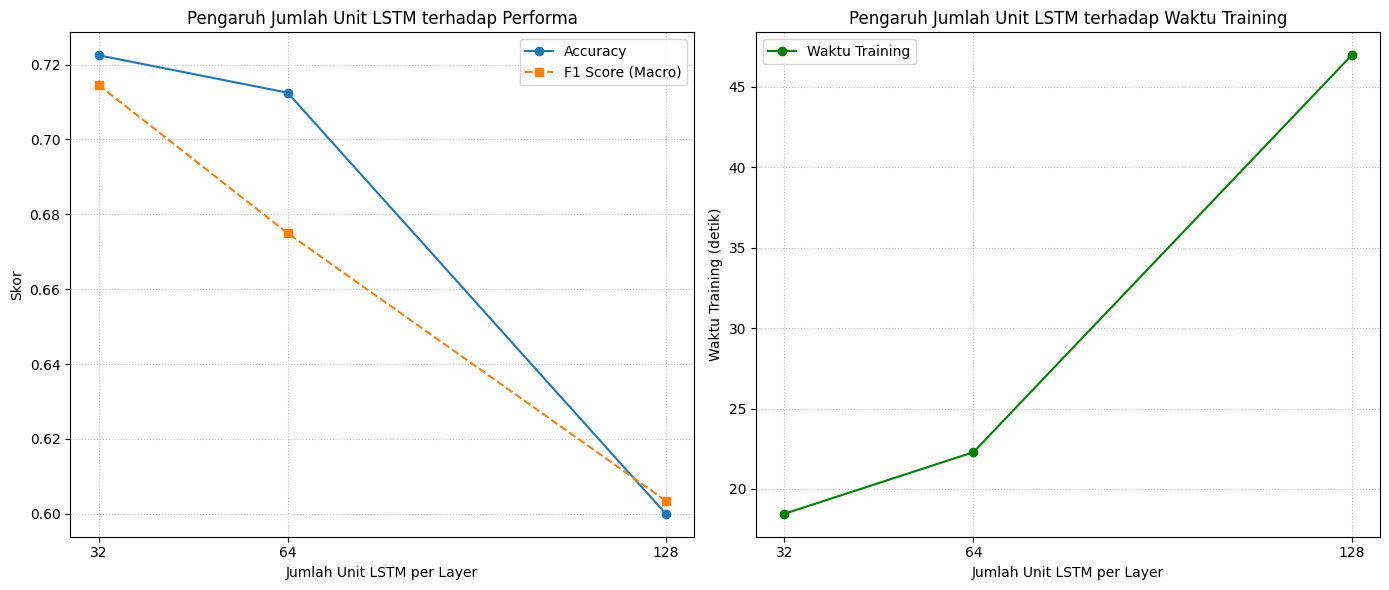

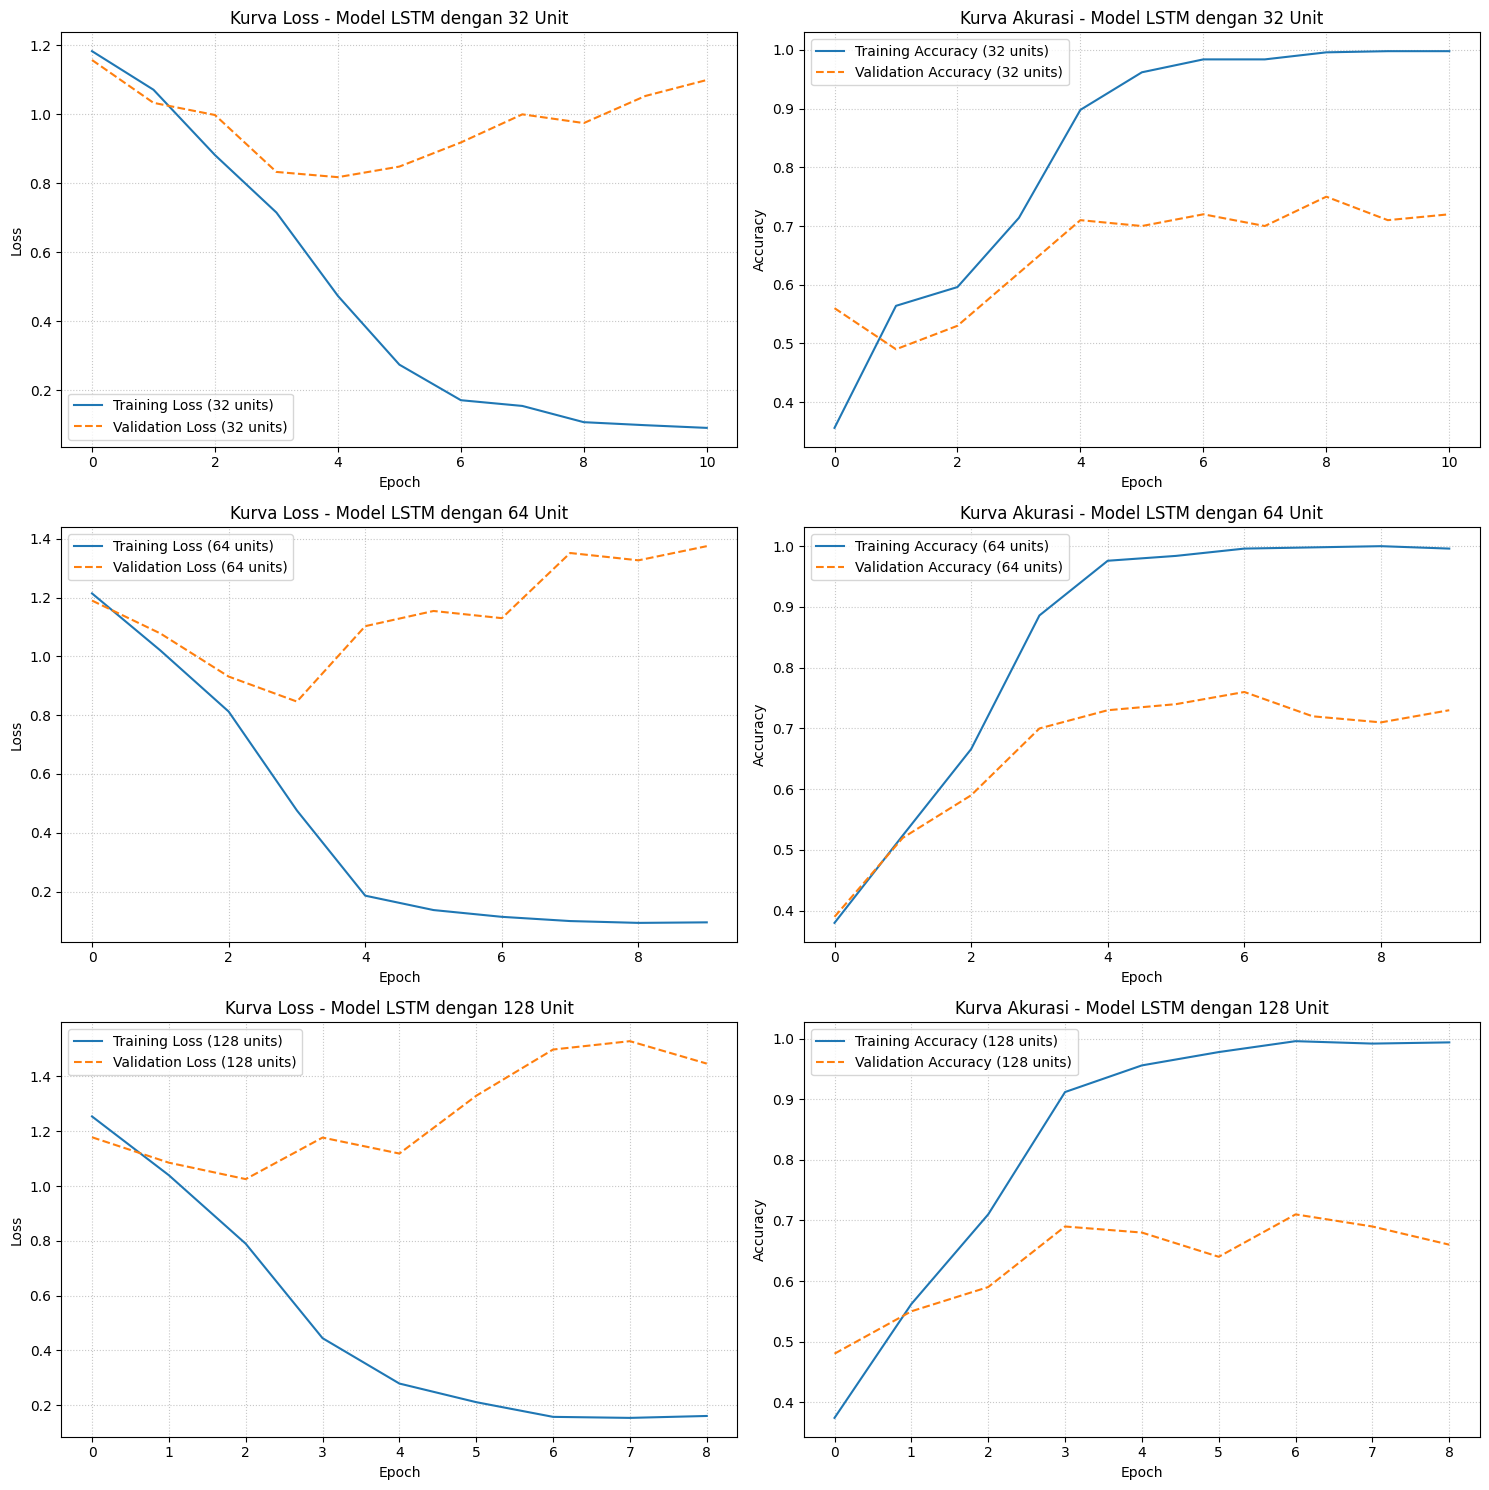

In [9]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Jumlah Unit LSTM:")
display(unit_results_df_lstm)

# Visualisasikan pengaruh jumlah unit LSTM
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(unit_results_df_lstm['num_lstm_units'], unit_results_df_lstm['accuracy'], 'o-', label='Accuracy')
plt.plot(unit_results_df_lstm['num_lstm_units'], unit_results_df_lstm['f1_score'], 's--', label='F1 Score (Macro)')
plt.xlabel('Jumlah Unit LSTM per Layer')
plt.ylabel('Skor')
plt.title('Pengaruh Jumlah Unit LSTM terhadap Performa')
plt.xticks(unit_results_df_lstm['num_lstm_units'])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(unit_results_df_lstm['num_lstm_units'], unit_results_df_lstm['train_time'], 'o-', color='green', label='Waktu Training')
plt.xlabel('Jumlah Unit LSTM per Layer')
plt.ylabel('Waktu Training (detik)')
plt.title('Pengaruh Jumlah Unit LSTM terhadap Waktu Training')
plt.xticks(unit_results_df_lstm['num_lstm_units'])
plt.grid(True, linestyle=':', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

# Plot kurva learning untuk setiap variasi jumlah unit LSTM
num_variations = len(LSTM_UNITS_VARIATIONS)
plt.figure(figsize=(15, 5 * num_variations))

for i, units in enumerate(LSTM_UNITS_VARIATIONS):
    history_data = unit_histories_lstm[units].history
    
    plt.subplot(num_variations, 2, 2*i + 1)
    plt.plot(history_data['loss'], label=f'Training Loss ({units} units)')
    plt.plot(history_data['val_loss'], '--', label=f'Validation Loss ({units} units)')
    plt.title(f'Kurva Loss - Model LSTM dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    
    plt.subplot(num_variations, 2, 2*i + 2)
    plt.plot(history_data['accuracy'], label=f'Training Accuracy ({units} units)')
    plt.plot(history_data['val_accuracy'], '--', label=f'Validation Accuracy ({units} units)')
    plt.title(f'Kurva Akurasi - Model LSTM dengan {units} Unit')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

## 3.3 Eksperimen LSTM Bidirectional vs Unidirectional
2 variasi arah LSTM: unidirectional dan bidirectional

In [10]:
def run_lstm_bidirectional_experiment():
    """Jalankan eksperimen untuk membandingkan LSTM satu arah vs dua arah"""
    print("\n" + "="*60)
    print("EKSPERIMEN LSTM: VARIASI ARAH LAYER LSTM (BIDIRECTIONAL)")
    print("="*60)
    
    results = []
    histories = {}
    
    # Uji untuk setiap setting bidirectional
    for is_bidirectional in BIDIRECTIONAL_LSTM_VARIATIONS:
        direction_name = "bidirectional_lstm" if is_bidirectional else "unidirectional_lstm"
        model_name = f"lstm_{direction_name}"
        print(f"\n--- Menguji model dengan LSTM {direction_name} ---")
        
        # Latih model dengan variasi ini
        _, history, _, _, _, metrics = train_and_evaluate_lstm_model(
            bidirectional=is_bidirectional, # Override parameter bidirectional
            model_name=model_name
        )
        
        # Simpan hasilnya
        results.append({
            'is_bidirectional_lstm': is_bidirectional,
            'direction_lstm': direction_name,
            'accuracy': metrics['test_accuracy'],
            'f1_score': metrics['test_f1'],
            'loss': metrics['test_loss'],
            'train_time': metrics['training_time']
        })
        
        # Simpan history untuk plot
        histories[direction_name] = history
        
    results_df = pd.DataFrame(results)
    csv_path = f"{RESULTS_DIR_LSTM}/lstm_bidirectional_results.csv"
    results_df.to_csv(csv_path, index=False)
    print(f"\nHasil eksperimen arah LSTM disimpan di {csv_path}")
    
    return results_df, histories

# Jalankan eksperimen variasi arah LSTM
bidirectional_results_df_lstm, bidirectional_histories_lstm = run_lstm_bidirectional_experiment()


EKSPERIMEN LSTM: VARIASI ARAH LAYER LSTM (BIDIRECTIONAL)

--- Menguji model dengan LSTM unidirectional_lstm ---

--- Training LSTM Model: lstm_unidirectional_lstm ---
Config: Layers=2, Units=64, Bidirectional=False, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_1 (LSTM)             │ (None, 80, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,635 (1.70 MB)

 Trainable params: 445,635 (1.70 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2316 - loss: 1.1856
Epoch 1: val_loss improved from inf to 1.15096, saving model to checkpoints/lstm_unidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.2368 - loss: 1.1843 - val_accuracy: 0.3800 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 2/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3844 - loss: 1.1411
Epoch 2: val_loss improved from 1.15096 to 1.14307, saving model to checkpoints/lstm_unidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.3835 - loss: 1.1421 - val_accuracy: 0.2400 - val_loss: 1.1431 - learning_rate: 0.0010
Epoch 3/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2712 - loss: 1.1214
Epoch 3: val_loss improved from 1.14307 to 1.13031, saving model to checkpoints/lstm_unidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.2738 - loss: 1.1234 - val_accuracy: 0

Test Loss: 1.1132
Test Accuracy: 0.3775
Test Macro F1: 0.1827

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       153
     neutral       0.00      0.00      0.00        96
    positive       0.38      1.00      0.55       151

    accuracy                           0.38       400
   macro avg       0.13      0.33      0.18       400
weighted avg       0.14      0.38      0.21       400

Model lengkap disimpan di: models/lstm_unidirectional_lstm_full_model.keras
Vectorizer disimpan di: models/lstm_unidirectional_lstm_vectorizer.keras

--- Menguji model dengan LSTM bidirectional_lstm ---

--- Training LSTM Model: lstm_bidirectional_lstm ---
Config: Layers=2, Units=64, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 80, 128)        │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 80, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_2            │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_2 (Dropout)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 561,027 (2.14 MB)

 Trainable params: 561,027 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.2824 - loss: 1.2414
Epoch 1: val_loss improved from inf to 1.17766, saving model to checkpoints/lstm_bidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 0.2872 - loss: 1.2398 - val_accuracy: 0.4500 - val_loss: 1.1777 - learning_rate: 0.0010
Epoch 2/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4918 - loss: 1.0544
Epoch 2: val_loss improved from 1.17766 to 1.06562, saving model to checkpoints/lstm_bidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.4948 - loss: 1.0521 - val_accuracy: 0.5200 - val_loss: 1.0656 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6281 - loss: 0.8328
Epoch 3: val_loss improved from 1.06562 to 0.94711, saving model to checkpoints/lstm_bidirectional_lstm.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.6297 - loss: 0.8311 - val_accuracy: 0.

Test Loss: 0.8817
Test Accuracy: 0.6375
Test Macro F1: 0.6375

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.58      0.53      0.55       153
     neutral       0.57      0.72      0.63        96
    positive       0.76      0.70      0.73       151

    accuracy                           0.64       400
   macro avg       0.64      0.65      0.64       400
weighted avg       0.64      0.64      0.64       400

Model lengkap disimpan di: models/lstm_bidirectional_lstm_full_model.keras
Vectorizer disimpan di: models/lstm_bidirectional_lstm_vectorizer.keras

Hasil eksperimen arah LSTM disimpan di experiment_results_lstm/lstm_bidirectional_results.csv


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)



Hasil Eksperimen Arah Layer LSTM:


,is_bidirectional_lstm,direction_lstm,accuracy,f1_score,loss,train_time
0,False,unidirectional_lstm,0.3775,0.182698,1.113184,20.618245
1,True,bidirectional_lstm,0.6375,0.637524,0.881745,20.836806


<Figure size 1000x700 with 0 Axes>

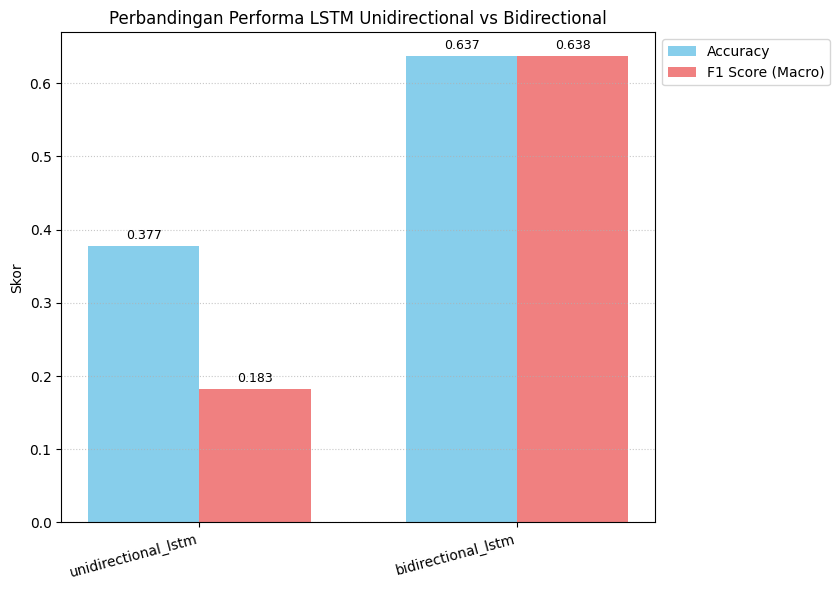

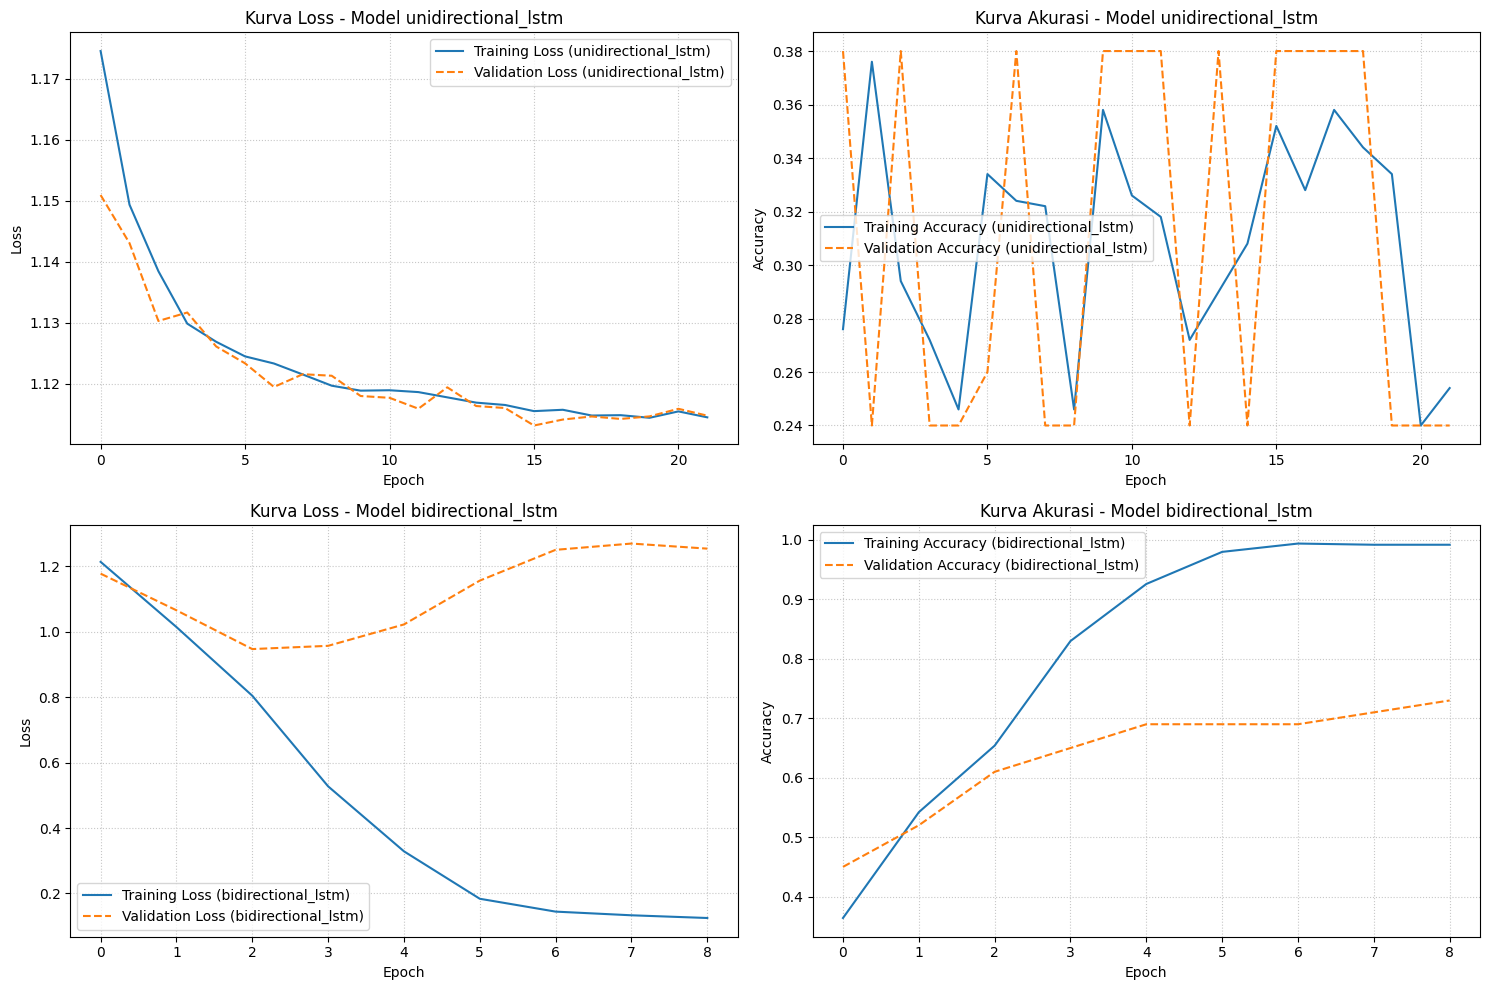

In [11]:
# Tampilkan hasil dalam tabel
print("\nHasil Eksperimen Arah Layer LSTM:")
display(bidirectional_results_df_lstm)

# Visualisasikan pengaruh arah LSTM dengan chart batang
plt.figure(figsize=(10, 7)) 
directions_lstm = bidirectional_results_df_lstm['direction_lstm'].tolist()
x_pos = np.arange(len(directions_lstm))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(10, 6)) # Buat figure dan axes terpisah
rects1 = ax.bar(x_pos - bar_width/2, bidirectional_results_df_lstm['accuracy'], bar_width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x_pos + bar_width/2, bidirectional_results_df_lstm['f1_score'], bar_width, label='F1 Score (Macro)', color='lightcoral')

ax.set_title('Perbandingan Performa LSTM Unidirectional vs Bidirectional')
ax.set_ylabel('Skor')
ax.set_xticks(x_pos)
ax.set_xticklabels(directions_lstm, rotation=15, ha="right") 
ax.legend(loc='upper left', bbox_to_anchor=(1,1)) 
ax.grid(axis='y', linestyle=':', alpha=0.7)

# Fungsi untuk menambahkan label nilai di atas bar
def autolabel_bars(rects, ax_obj):
    for rect in rects:
        height = rect.get_height()
        ax_obj.annotate(f'{height:.3f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3), # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom', fontsize=9)

autolabel_bars(rects1, ax)
autolabel_bars(rects2, ax)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()


# Plot kurva learning untuk perbandingan bidirectional vs unidirectional LSTM
num_variations = len(BIDIRECTIONAL_LSTM_VARIATIONS)
plt.figure(figsize=(15, 5 * num_variations))

for i, (direction, history_obj) in enumerate(bidirectional_histories_lstm.items()):
    history_data = history_obj.history
    
    plt.subplot(num_variations, 2, 2*i + 1)
    plt.plot(history_data['loss'], label=f'Training Loss ({direction})')
    plt.plot(history_data['val_loss'], '--', label=f'Validation Loss ({direction})')
    plt.title(f'Kurva Loss - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)
    
    plt.subplot(num_variations, 2, 2*i + 2)
    plt.plot(history_data['accuracy'], label=f'Training Accuracy ({direction})')
    plt.plot(history_data['val_accuracy'], '--', label=f'Validation Accuracy ({direction})')
    plt.title(f'Kurva Akurasi - Model {direction}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.7)

plt.tight_layout()
plt.show()

## 3.4. Analisis dan Model Optimal


ANALISIS KOMPREHENSIF SEMUA VARIASI LSTM
Rangkuman komprehensif LSTM disimpan di experiment_results_lstm/lstm_variation_summary.csv

Rangkuman Dampak Variasi LSTM:


,Variasi LSTM,Konfigurasi Terbaik,Akurasi Terbaik (dari F1),F1 Score Terbaik,Dampak Relatif (F1)
0,"Layer: Terbaik dari [1, 2, 3]",1 layer(s),0.7400,0.7319,0.0868
1,"Unit: Terbaik dari [32, 64, 128]",32 unit(s),0.7225,0.7146,0.1111
2,"Arah: Terbaik dari ['Unidirectional', 'Bidirectional']",Bidirectional LSTM,0.6375,0.6375,0.4548



Variasi LSTM dengan dampak terbesar pada F1 score: Arah Layer LSTM
Rentang dampak: 0.4548 perbedaan F1 score


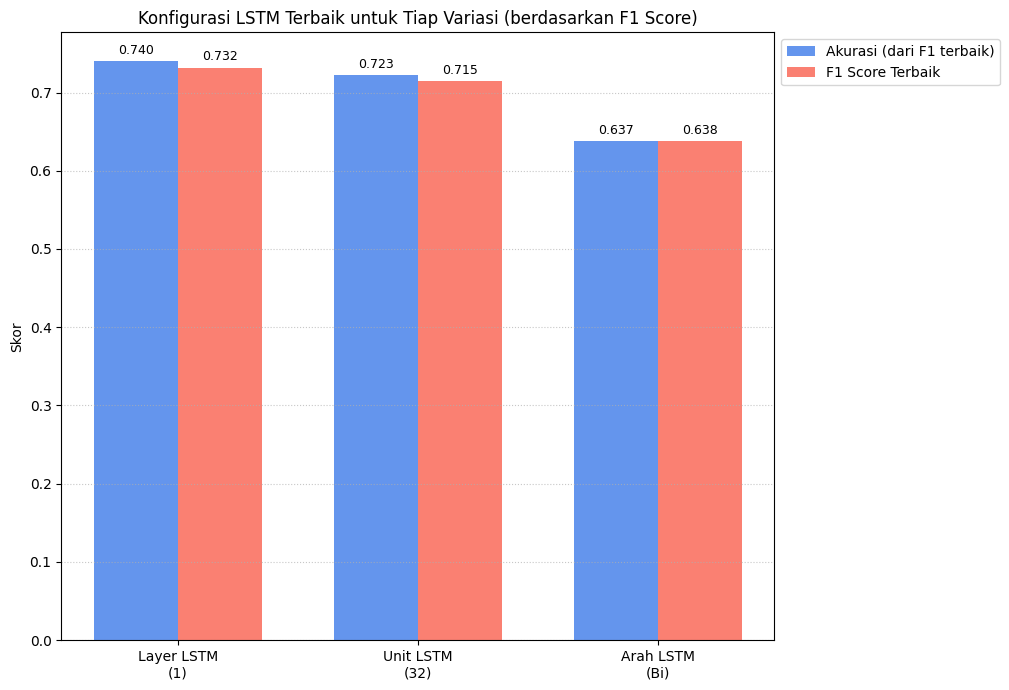


Konfigurasi LSTM optimal berdasarkan F1 score dari tiap kategori:
- Jumlah layer LSTM: 1
- Jumlah unit LSTM: 32
- Bidirectional LSTM: True


In [12]:
def analyze_all_lstm_results(layer_results_df, unit_results_df, bidirectional_results_df):
    """Analisis komprehensif dari semua hasil eksperimen LSTM"""
    
    print("\n" + "="*60)
    print("ANALISIS KOMPREHENSIF SEMUA VARIASI LSTM")
    print("="*60)
    
    if layer_results_df.empty or 'f1_score' not in layer_results_df.columns or 'num_lstm_layers' not in layer_results_df.columns:
        print("Peringatan: layer_results_df_lstm kosong atau tidak memiliki kolom yang diperlukan.")
        best_layer_config = "N/A"
        best_layer_f1 = 0.0
        best_layer_acc = 0.0
        layer_impact = 0.0
    else:
        best_layer_idx = layer_results_df['f1_score'].idxmax()
        best_layer_config = f"{layer_results_df.loc[best_layer_idx, 'num_lstm_layers']} layer(s)"
        best_layer_f1 = layer_results_df['f1_score'].max()
        best_layer_acc = layer_results_df.loc[best_layer_idx, 'accuracy'] # Akurasi dari konfigurasi F1 terbaik
        layer_impact = layer_results_df['f1_score'].max() - layer_results_df['f1_score'].min()

    if unit_results_df.empty or 'f1_score' not in unit_results_df.columns or 'num_lstm_units' not in unit_results_df.columns:
        print("Peringatan: unit_results_df_lstm kosong atau tidak memiliki kolom yang diperlukan.")
        best_unit_config = "N/A"
        best_unit_f1 = 0.0
        best_unit_acc = 0.0
        unit_impact = 0.0
    else:
        best_unit_idx = unit_results_df['f1_score'].idxmax()
        best_unit_config = f"{unit_results_df.loc[best_unit_idx, 'num_lstm_units']} unit(s)"
        best_unit_f1 = unit_results_df['f1_score'].max()
        best_unit_acc = unit_results_df.loc[best_unit_idx, 'accuracy']
        unit_impact = unit_results_df['f1_score'].max() - unit_results_df['f1_score'].min()

    if bidirectional_results_df.empty or 'f1_score' not in bidirectional_results_df.columns or 'is_bidirectional_lstm' not in bidirectional_results_df.columns:
        print("Peringatan: bidirectional_results_df_lstm kosong atau tidak memiliki kolom yang diperlukan.")
        best_direction_config = "N/A"
        best_direction_f1 = 0.0
        best_direction_acc = 0.0
        direction_impact = 0.0
    else:
        best_direction_idx = bidirectional_results_df['f1_score'].idxmax()
        best_direction_config = "Bidirectional LSTM" if bidirectional_results_df.loc[best_direction_idx, 'is_bidirectional_lstm'] else "Unidirectional LSTM"
        best_direction_f1 = bidirectional_results_df['f1_score'].max()
        best_direction_acc = bidirectional_results_df.loc[best_direction_idx, 'accuracy']
        direction_impact = bidirectional_results_df['f1_score'].max() - bidirectional_results_df['f1_score'].min()

    # Buat tabel rangkuman
    summary_lstm = pd.DataFrame({
        'Variasi LSTM': [
            f"Layer: Terbaik dari {LSTM_LAYERS_VARIATIONS}",
            f"Unit: Terbaik dari {LSTM_UNITS_VARIATIONS}",
            f"Arah: Terbaik dari {['Unidirectional', 'Bidirectional']}"
        ],
        'Konfigurasi Terbaik': [
            best_layer_config,
            best_unit_config,
            best_direction_config
        ],
        'Akurasi Terbaik (dari F1)': [ # Akurasi dari konfigurasi dengan F1 terbaik
            f"{best_layer_acc:.4f}",
            f"{best_unit_acc:.4f}",
            f"{best_direction_acc:.4f}"
        ],
        'F1 Score Terbaik': [
            f"{best_layer_f1:.4f}",
            f"{best_unit_f1:.4f}",
            f"{best_direction_f1:.4f}"
        ],
        'Dampak Relatif (F1)': [
            f"{layer_impact:.4f}",
            f"{unit_impact:.4f}",
            f"{direction_impact:.4f}"
        ]
    })
    
    # Simpan rangkuman ke CSV
    summary_path_lstm = f"{RESULTS_DIR_LSTM}/lstm_variation_summary.csv"
    summary_lstm.to_csv(summary_path_lstm, index=False)
    print(f"Rangkuman komprehensif LSTM disimpan di {summary_path_lstm}")
    
    # Cetak analisis
    print("\nRangkuman Dampak Variasi LSTM:")
    display(summary_lstm)
    
    # Tentukan variasi mana yang memberikan dampak terbesar
    impacts_lstm = [layer_impact, unit_impact, direction_impact]
    variation_names_lstm = ['Jumlah Layer LSTM', 'Jumlah Unit LSTM', 'Arah Layer LSTM']
    
    if not impacts_lstm or all(i == 0.0 for i in impacts_lstm): # Handle jika semua impact 0 atau list kosong
        most_impactful_lstm = "N/A (tidak ada dampak atau data tidak cukup)"
        max_impact_val_lstm = 0.0
    else:
        most_impactful_lstm = variation_names_lstm[np.argmax(impacts_lstm)]
        max_impact_val_lstm = max(impacts_lstm)

    print(f"\nVariasi LSTM dengan dampak terbesar pada F1 score: {most_impactful_lstm}")
    print(f"Rentang dampak: {max_impact_val_lstm:.4f} perbedaan F1 score")
    
    # Visualisasikan konfigurasi terbaik untuk setiap variasi LSTM
    variations_plot_lstm = ['Layer LSTM', 'Unit LSTM', 'Arah LSTM']
    best_configs_plot_lstm = [
        f"{layer_results_df.loc[layer_results_df['f1_score'].idxmax(), 'num_lstm_layers'] if not layer_results_df.empty else 'N/A'}",
        f"{unit_results_df.loc[unit_results_df['f1_score'].idxmax(), 'num_lstm_units'] if not unit_results_df.empty else 'N/A'}",
        f"{'Bi' if bidirectional_results_df.loc[bidirectional_results_df['f1_score'].idxmax(), 'is_bidirectional_lstm'] else 'Uni'}" if not bidirectional_results_df.empty else "N/A"
    ]
    
    best_accuracies_plot_lstm = [best_layer_acc, best_unit_acc, best_direction_acc]
    best_f1s_plot_lstm = [best_layer_f1, best_unit_f1, best_direction_f1]
    
    # Buat label untuk sumbu x yang menunjukkan konfigurasi terbaik
    x_labels_lstm = [f"{v}\n({c})" for v, c in zip(variations_plot_lstm, best_configs_plot_lstm)]
    
    # Plot
    x_lstm = np.arange(len(variations_plot_lstm))
    width_lstm = 0.35
    
    fig_lstm, ax_lstm = plt.subplots(figsize=(12, 7)) # Sedikit lebih lebar
    rects1_lstm = ax_lstm.bar(x_lstm - width_lstm/2, best_accuracies_plot_lstm, width_lstm, label='Akurasi (dari F1 terbaik)', color='cornflowerblue')
    rects2_lstm = ax_lstm.bar(x_lstm + width_lstm/2, best_f1s_plot_lstm, width_lstm, label='F1 Score Terbaik', color='salmon')
    
    ax_lstm.set_title('Konfigurasi LSTM Terbaik untuk Tiap Variasi (berdasarkan F1 Score)')
    ax_lstm.set_ylabel('Skor')
    ax_lstm.set_xticks(x_lstm)
    ax_lstm.set_xticklabels(x_labels_lstm)
    ax_lstm.legend(loc='upper left', bbox_to_anchor=(1,1)) # Pindahkan legend
    ax_lstm.grid(axis='y', linestyle=':', alpha=0.7)
    
    # Tambahkan nilai di atas batang
    def autolabel_bars_summary(rects, ax_obj):
        for rect in rects:
            height = rect.get_height()
            ax_obj.annotate(f'{height:.3f}',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3), # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom', fontsize=9)
    
    autolabel_bars_summary(rects1_lstm, ax_lstm)
    autolabel_bars_summary(rects2_lstm, ax_lstm)
    
    fig_lstm.tight_layout(rect=[0, 0, 0.85, 1]) 
    plt.show()
    
    optimal_config_lstm = {}
    if not layer_results_df.empty:
        optimal_config_lstm['num_lstm_layers'] = int(layer_results_df.loc[layer_results_df['f1_score'].idxmax(), 'num_lstm_layers'])
    else:
        optimal_config_lstm['num_lstm_layers'] = config.NUM_LSTM_LAYERS # Default jika tidak ada hasil

    if not unit_results_df.empty:
        optimal_config_lstm['lstm_units'] = int(unit_results_df.loc[unit_results_df['f1_score'].idxmax(), 'num_lstm_units'])
    else:
        optimal_config_lstm['lstm_units'] = config.LSTM_UNITS # Default

    if not bidirectional_results_df.empty:
        optimal_config_lstm['bidirectional_lstm'] = bool(bidirectional_results_df.loc[bidirectional_results_df['f1_score'].idxmax(), 'is_bidirectional_lstm'])
    else:
        optimal_config_lstm['bidirectional_lstm'] = config.BIDIRECTIONAL_LSTM # Default
    
    print("\nKonfigurasi LSTM optimal berdasarkan F1 score dari tiap kategori:")
    print(f"- Jumlah layer LSTM: {optimal_config_lstm.get('num_lstm_layers', 'N/A')}")
    print(f"- Jumlah unit LSTM: {optimal_config_lstm.get('lstm_units', 'N/A')}")
    print(f"- Bidirectional LSTM: {optimal_config_lstm.get('bidirectional_lstm', 'N/A')}")
    
    return optimal_config_lstm

optimal_config_lstm = analyze_all_lstm_results(layer_results_df_lstm, unit_results_df_lstm, bidirectional_results_df_lstm)


PELATIHAN MODEL LSTM DENGAN KONFIGURASI OPTIMAL

Pelatihan model LSTM optimal: optimal_lstm_l1_u32_bi
Konfigurasi: {'num_lstm_layers': 1, 'lstm_units': 32, 'bidirectional_lstm': True, 'source': 'Determined from experiments'}

--- Training LSTM Model: optimal_lstm_l1_u32_bi ---
Config: Layers=1, Units=32, Bidirectional=True, Dropout=0.2, EmbDropout=0.1, RecDropout=0.05, L2=0.0001
Ukuran dataset: Train=500, Valid=100, Test=400
Distribusi kelas di data train: [192 119 189]
Menggunakan bobot kelas: {0: 0.8680555555555556, 1: 1.4005602240896358, 2: 0.8818342151675485}
Ukuran vocabulary: 2836


Model: "LSTM_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 80, 128)        │       363,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_dropout               │ (None, 80, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_lstm_1            │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_lstm_1 (Dropout)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense_layer (Dense)      │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,419 (1.54 MB)

 Trainable params: 404,419 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

Mulai pelatihan model LSTM...
Epoch 1/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3330 - loss: 1.1661
Epoch 1: val_loss improved from inf to 1.12991, saving model to checkpoints/optimal_lstm_l1_u32_bi.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.3430 - loss: 1.1644 - val_accuracy: 0.5500 - val_loss: 1.1299 - learning_rate: 0.0010
Epoch 2/24
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5924 - loss: 1.0767
Epoch 2: val_loss improved from 1.12991 to 1.05947, saving model to checkpoints/optimal_lstm_l1_u32_bi.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5881 - loss: 1.0749 - val_accuracy: 0.5400 - val_loss: 1.0595 - learning_rate: 0.0010
Epoch 3/24
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6229 - loss: 0.9413
Epoch 3: val_loss improved from 1.05947 to 1.01835, saving model to checkpoints/optimal_lstm_l1_u32_bi.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6234 - loss: 0.9402 - val_accuracy: 0.5200 

Test Loss: 0.7094
Test Accuracy: 0.7275
Test Macro F1: 0.7082

Laporan Klasifikasi:
              precision    recall  f1-score   support

    negative       0.61      0.86      0.72       153
     neutral       0.74      0.48      0.58        96
    positive       0.92      0.75      0.82       151

    accuracy                           0.73       400
   macro avg       0.76      0.70      0.71       400
weighted avg       0.76      0.73      0.73       400

Model lengkap disimpan di: models/optimal_lstm_l1_u32_bi_full_model.keras
Vectorizer disimpan di: models/optimal_lstm_l1_u32_bi_vectorizer.keras

Performa Model LSTM Optimal:
- test_loss: 0.7094
- test_accuracy: 0.7275
- test_f1: 0.7082
- training_time: 12.9047


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_api.py:107: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  return saving_lib.save_model(model, filepath)


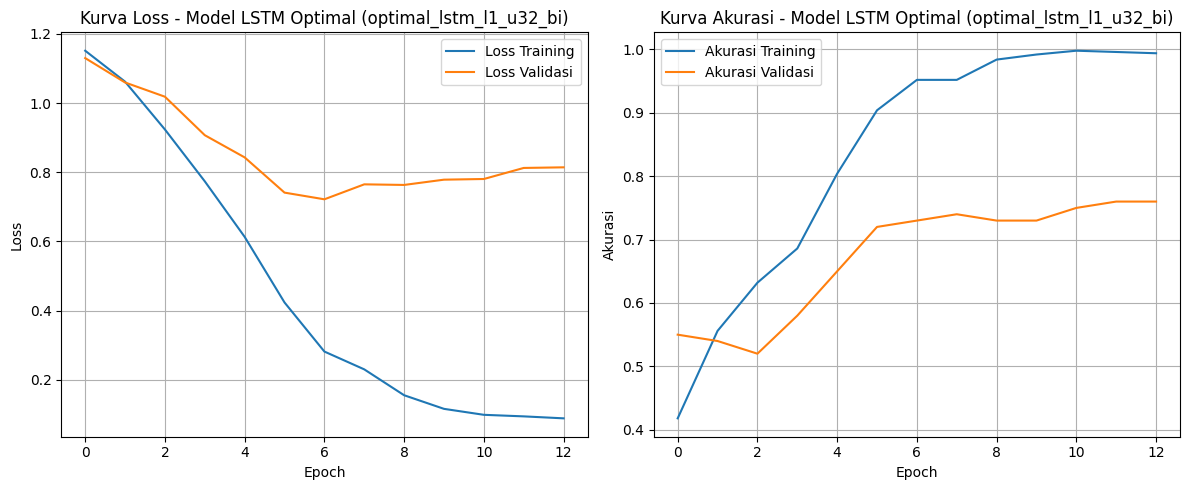

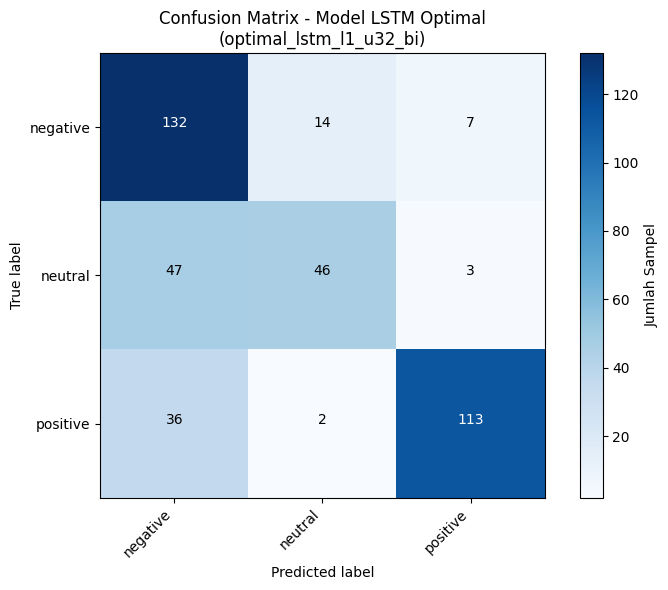


Laporan Klasifikasi Model LSTM Optimal:
              precision    recall  f1-score   support

    negative       0.61      0.86      0.72       153
     neutral       0.74      0.48      0.58        96
    positive       0.92      0.75      0.82       151

    accuracy                           0.73       400
   macro avg       0.76      0.70      0.71       400
weighted avg       0.76      0.73      0.73       400



In [13]:
def run_optimal_lstm_model(optimal_config):
    """Latih model LSTM dengan konfigurasi optimal dari hasil eksperimen"""
    print("\n" + "="*60)
    print("PELATIHAN MODEL LSTM DENGAN KONFIGURASI OPTIMAL")
    print("="*60)
    
    if not optimal_config or not all(k in optimal_config for k in ['num_lstm_layers', 'lstm_units', 'bidirectional_lstm']):
        print("Konfigurasi optimal LSTM tidak lengkap atau tidak ditemukan. Menggunakan default dari config.py.")
        num_layers = config.NUM_LSTM_LAYERS
        units = config.LSTM_UNITS
        bidir = config.BIDIRECTIONAL_LSTM
        optimal_config_display = {
            'num_lstm_layers': num_layers,
            'lstm_units': units,
            'bidirectional_lstm': bidir,
            'source': 'Defaults from config.py'
        }
    else:
        num_layers = optimal_config['num_lstm_layers']
        units = optimal_config['lstm_units']
        bidir = optimal_config['bidirectional_lstm']
        optimal_config_display = optimal_config.copy()
        optimal_config_display['source'] = 'Determined from experiments'

    # Buat nama model yang menggambarkan konfigurasinya
    model_name_optimal_lstm = f"optimal_lstm_l{num_layers}_u{units}_{'bi' if bidir else 'uni'}"
    
    print(f"\nPelatihan model LSTM optimal: {model_name_optimal_lstm}")
    print(f"Konfigurasi: {optimal_config_display}")
    
    model_opt, history_opt, preds_opt, labels_true_opt, vectorizer_opt, metrics_opt = train_and_evaluate_lstm_model(
        num_lstm_layers=num_layers,
        lstm_units=units,
        bidirectional=bidir,
        model_name=model_name_optimal_lstm
    )
    
    print("\nPerforma Model LSTM Optimal:")
    for metric_name, value in metrics_opt.items():
        if isinstance(value, float):
            print(f"- {metric_name}: {value:.4f}")
        else:
            print(f"- {metric_name}: {value}")

    # Plot kurva training
    plot_training_history(history_opt, f"Model LSTM Optimal ({model_name_optimal_lstm})")
    
    # Tambahkan confusion matrix untuk model optimal LSTM
    y_pred_opt_classes = np.argmax(preds_opt, axis=1)
    cm_opt_lstm = confusion_matrix(labels_true_opt, y_pred_opt_classes)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm_opt_lstm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - Model LSTM Optimal\n({model_name_optimal_lstm})')
    plt.colorbar(label='Jumlah Sampel')
    class_names_opt = list(label_mapping.keys()) 
    tick_marks_opt = np.arange(len(class_names_opt))
    plt.xticks(tick_marks_opt, class_names_opt, rotation=45, ha="right")
    plt.yticks(tick_marks_opt, class_names_opt)
    
    thresh_opt = cm_opt_lstm.max() / 2.
    for i in range(cm_opt_lstm.shape[0]):
        for j in range(cm_opt_lstm.shape[1]):
            plt.text(j, i, format(cm_opt_lstm[i, j], 'd'),
                    horizontalalignment="center",
                    color="white" if cm_opt_lstm[i, j] > thresh_opt else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    print("\nLaporan Klasifikasi Model LSTM Optimal:")
    print(classification_report(labels_true_opt, y_pred_opt_classes, target_names=class_names_opt, zero_division=0))
    
    return model_opt, vectorizer_opt, metrics_opt, model_name_optimal_lstm

# Latih model LSTM dengan konfigurasi optimal
optimal_lstm_model, optimal_lstm_vectorizer, optimal_lstm_metrics, optimal_lstm_model_name = run_optimal_lstm_model(optimal_config_lstm)

# 4. Implementasi Forward Propagation dari Awal (From Scratch)
Di sini kita mengimplementasikan forward propagation dari awal menggunakan NumPy dan membandingkannya dengan implementasi Keras.

## 4.1 Pengujian Forward Propagation pada Model Optimal


Menggunakan model Keras LSTM optimal dari: models/optimal_lstm_l1_u32_bi_full_model.keras
Menggunakan vectorizer dari: models/optimal_lstm_l1_u32_bi_vectorizer.keras

LSTM FROM SCRATCH IMPLEMENTATION COMPARISON (ROBUST)
Loaded test data: 400 samples
Loading Keras LSTM model from: models/optimal_lstm_l1_u32_bi_full_model.keras
Loading vectorizer from: models/optimal_lstm_l1_u32_bi_vectorizer.keras

Extracting weights from Keras LSTM model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 128)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_lstm_1 (Type: Bidirectional)
  Extracted Bidirectional Forward LSTM (forward_lstm_layer_1) weights with prefix 'bidir_fwd_lstm_1_'
  Extracted Bidirectional Backward LSTM (backward_lstm_layer_1) weights with prefix 'bidir_bwd_lstm_1_'
Processing layer: dropout_lstm_1 (Type: Dropout)
Processing layer: output_dense_layer (Type: Dense)
  Extracted output dense

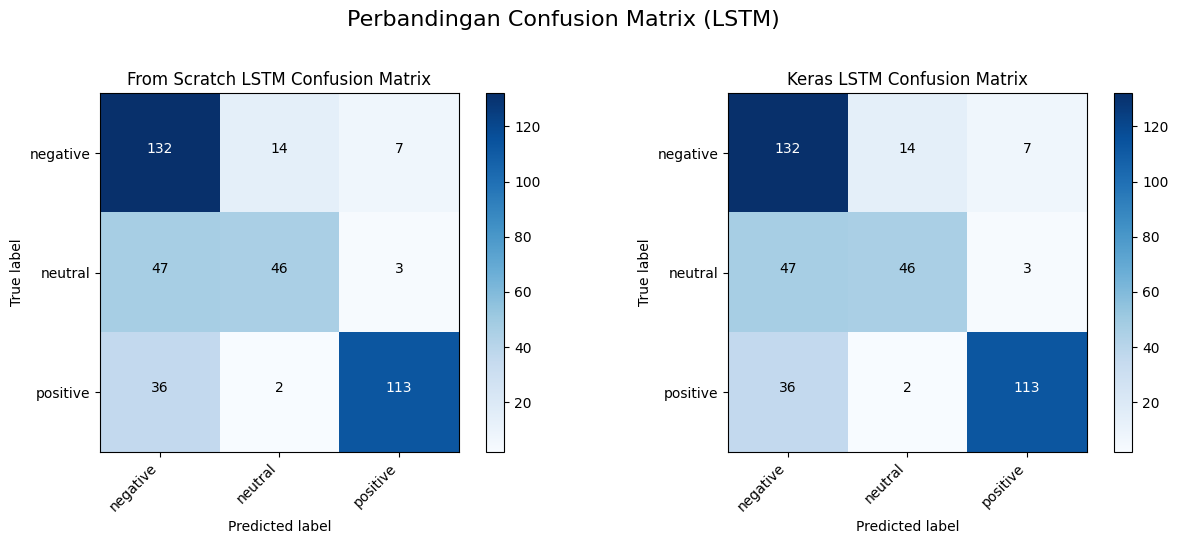

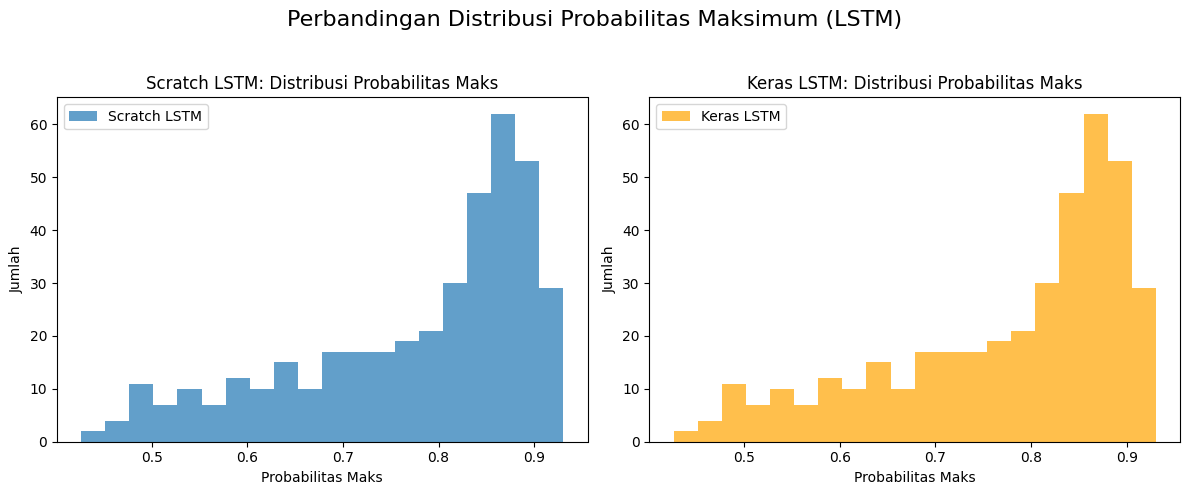

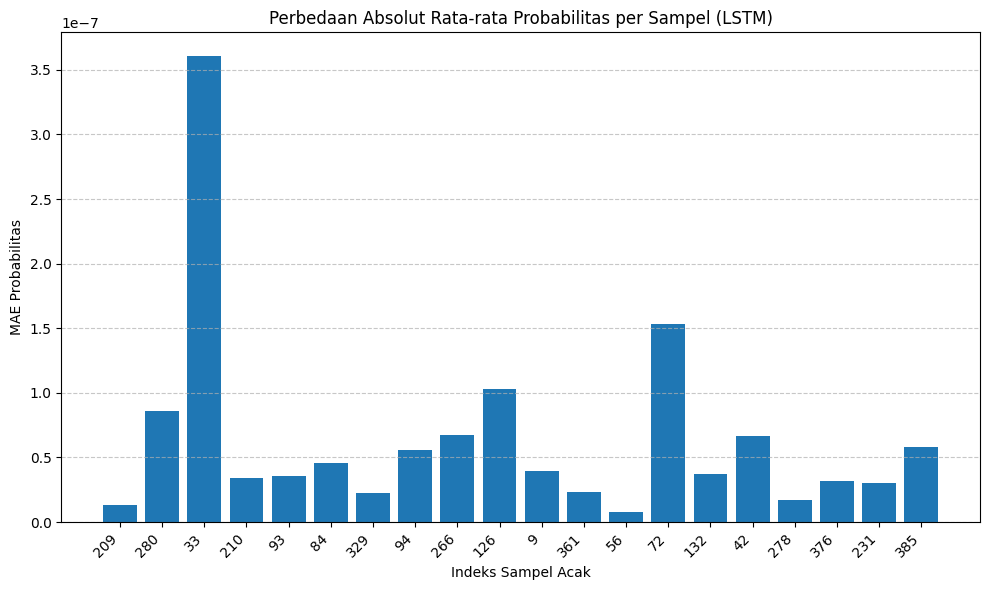

In [14]:
from from_scratch_lstm import LSTMFromScratch, run_lstm_from_scratch_comparison 

keras_model_path_lstm = f"models/{optimal_lstm_model_name}_full_model.keras"
vectorizer_path_lstm = f"models/{optimal_lstm_model_name}_vectorizer.keras"

print(f"\nMenggunakan model Keras LSTM optimal dari: {keras_model_path_lstm}")
print(f"Menggunakan vectorizer dari: {vectorizer_path_lstm}")

# Cek apakah file model dan vectorizer ada
if not os.path.exists(keras_model_path_lstm):
    print(f"PERINGATAN: File model Keras LSTM tidak ditemukan di {keras_model_path_lstm}")
    print("Pastikan model optimal telah dilatih dan disimpan dengan benar.")
if not os.path.exists(vectorizer_path_lstm):
    print(f"PERINGATAN: File vectorizer tidak ditemukan di {vectorizer_path_lstm}")
    print("Pastikan vectorizer telah disimpan dengan benar.")


if os.path.exists(keras_model_path_lstm) and os.path.exists(vectorizer_path_lstm):
    scratch_lstm_instance = run_lstm_from_scratch_comparison(keras_model_path_lstm, vectorizer_path_lstm)
else:
    print("\nPerbandingan LSTM from scratch tidak dapat dijalankan karena file model/vectorizer tidak ditemukan.")
    scratch_lstm_instance = None 

## 4.2. Pengujian Forward Propagation pada Model Lain


PERSIAPAN UJI FROM SCRATCH: 1 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/lstm_layers_2_full_model.keras
Akan menggunakan vectorizer dari: models/lstm_layers_2_vectorizer.keras

LSTM FROM SCRATCH IMPLEMENTATION COMPARISON (ROBUST)
Loaded test data: 400 samples
Loading Keras LSTM model from: models/lstm_layers_2_full_model.keras
Loading vectorizer from: models/lstm_layers_2_vectorizer.keras

Extracting weights from Keras LSTM model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 128)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_lstm_1 (Type: Bidirectional)
  Extracted Bidirectional Forward LSTM (forward_lstm_layer_1) weights with prefix 'bidir_fwd_lstm_1_'
  Extracted Bidirectional Backward LSTM (backward_lstm_layer_1) weights with prefix 'bidir_bwd_lstm_1_'
Processing layer: dropout_lstm_1 (Type: Dropout)
Processing layer:

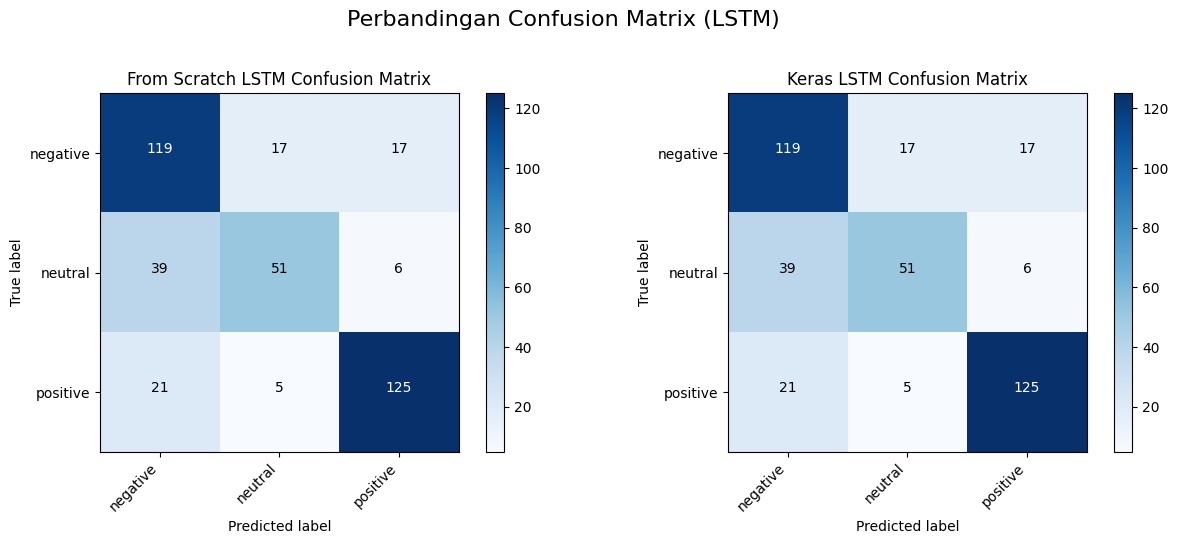

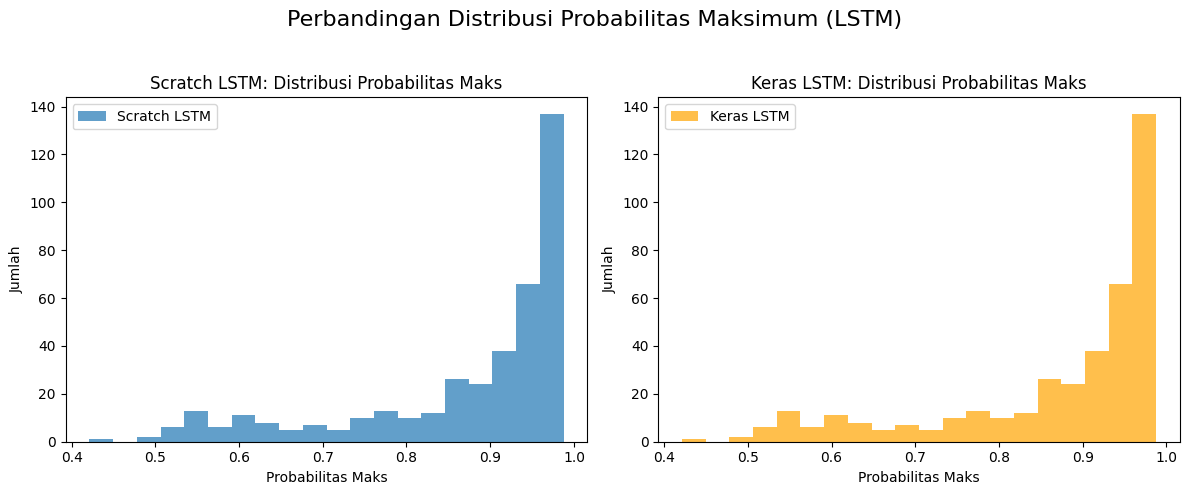

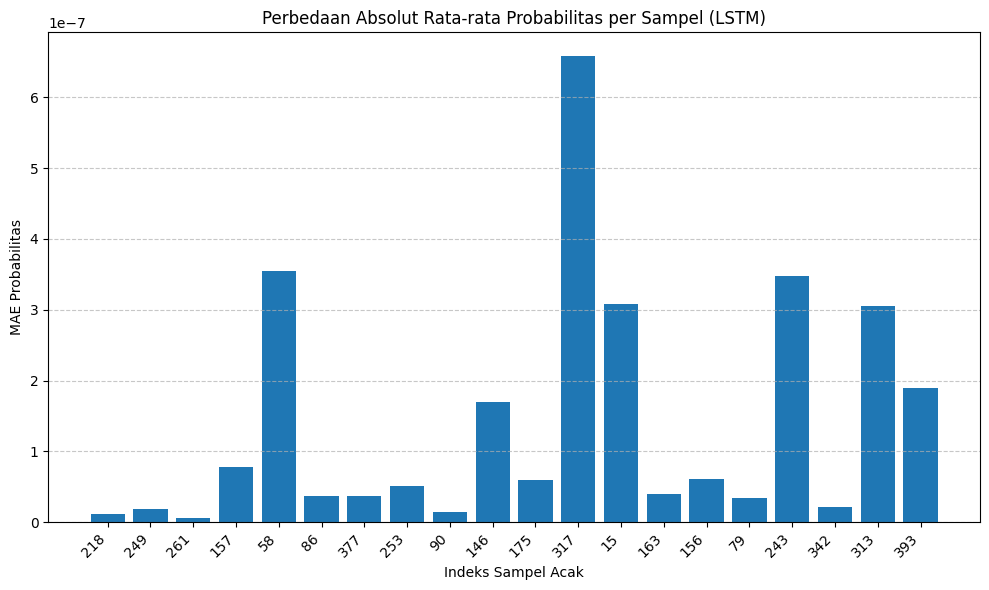

In [16]:
print("\n" + "="*60)
print("PERSIAPAN UJI FROM SCRATCH: 1 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l1_bi_exp = "lstm_layers_2" 

keras_model_path_l1_bi_exp = f"models/{model_name_l1_bi_exp}_full_model.keras"
vectorizer_path_l1_bi_exp = f"models/{model_name_l1_bi_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l1_bi_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l1_bi_exp}")

scratch_rnn_l1_bi_exp = run_lstm_from_scratch_comparison(keras_model_path_l1_bi_exp, vectorizer_path_l1_bi_exp)


PERSIAPAN UJI FROM SCRATCH: 2 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/lstm_layers_2_full_model.keras
Akan menggunakan vectorizer dari: models/lstm_layers_2_vectorizer.keras

LSTM FROM SCRATCH IMPLEMENTATION COMPARISON (ROBUST)
Loaded test data: 400 samples
Loading Keras LSTM model from: models/lstm_layers_2_full_model.keras
Loading vectorizer from: models/lstm_layers_2_vectorizer.keras

Extracting weights from Keras LSTM model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 128)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_lstm_1 (Type: Bidirectional)
  Extracted Bidirectional Forward LSTM (forward_lstm_layer_1) weights with prefix 'bidir_fwd_lstm_1_'
  Extracted Bidirectional Backward LSTM (backward_lstm_layer_1) weights with prefix 'bidir_bwd_lstm_1_'
Processing layer: dropout_lstm_1 (Type: Dropout)
Processing layer:

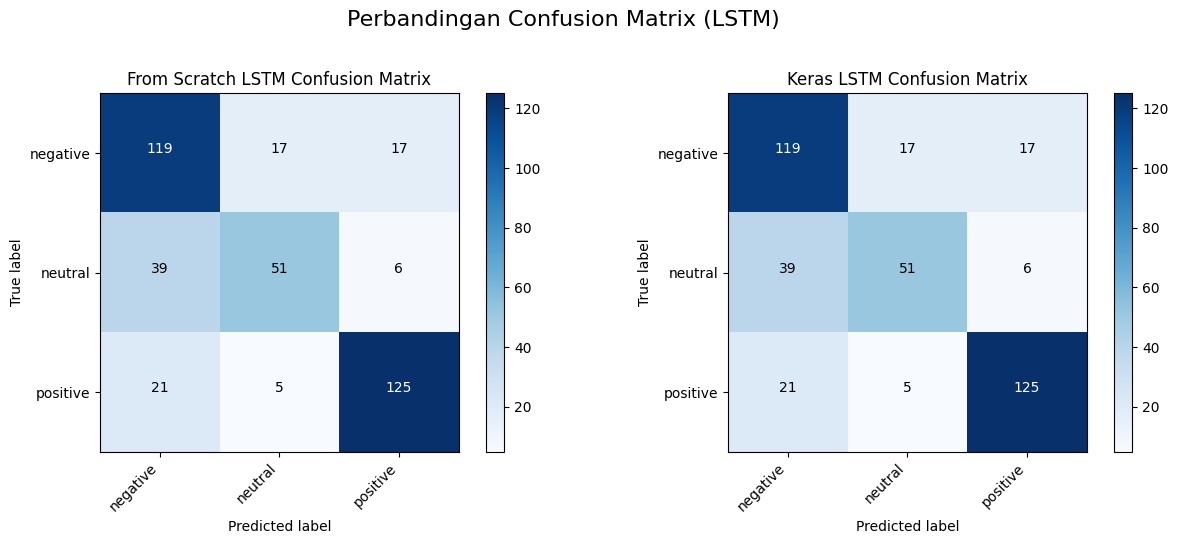

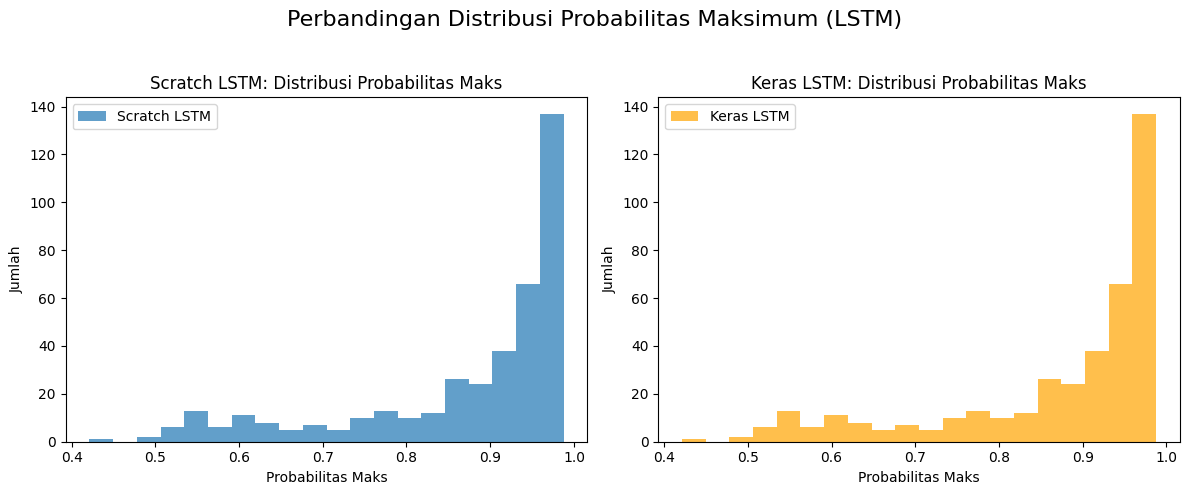

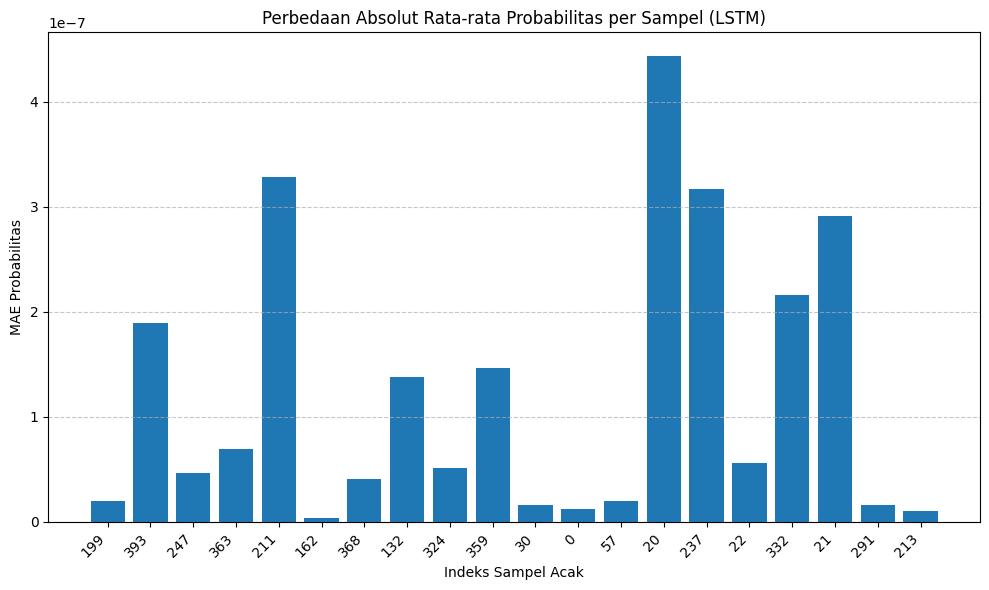

In [17]:
print("\n" + "="*60)
print("PERSIAPAN UJI FROM SCRATCH: 2 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l2_bi_exp = "lstm_layers_2" 

keras_model_path_l2_bi_exp = f"models/{model_name_l2_bi_exp}_full_model.keras"
vectorizer_path_l2_bi_exp = f"models/{model_name_l2_bi_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l2_bi_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l2_bi_exp}")

scratch_rnn_l2_bi_exp = run_lstm_from_scratch_comparison(keras_model_path_l2_bi_exp, vectorizer_path_l2_bi_exp)


PERSIAPAN UJI FROM SCRATCH: 3 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/lstm_layers_3_full_model.keras
Akan menggunakan vectorizer dari: models/lstm_layers_3_vectorizer.keras

LSTM FROM SCRATCH IMPLEMENTATION COMPARISON (ROBUST)
Loaded test data: 400 samples
Loading Keras LSTM model from: models/lstm_layers_3_full_model.keras
Loading vectorizer from: models/lstm_layers_3_vectorizer.keras

Extracting weights from Keras LSTM model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 128)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: bidirectional_lstm_1 (Type: Bidirectional)
  Extracted Bidirectional Forward LSTM (forward_lstm_layer_1) weights with prefix 'bidir_fwd_lstm_1_'
  Extracted Bidirectional Backward LSTM (backward_lstm_layer_1) weights with prefix 'bidir_bwd_lstm_1_'
Processing layer: dropout_lstm_1 (Type: Dropout)
Processing layer:

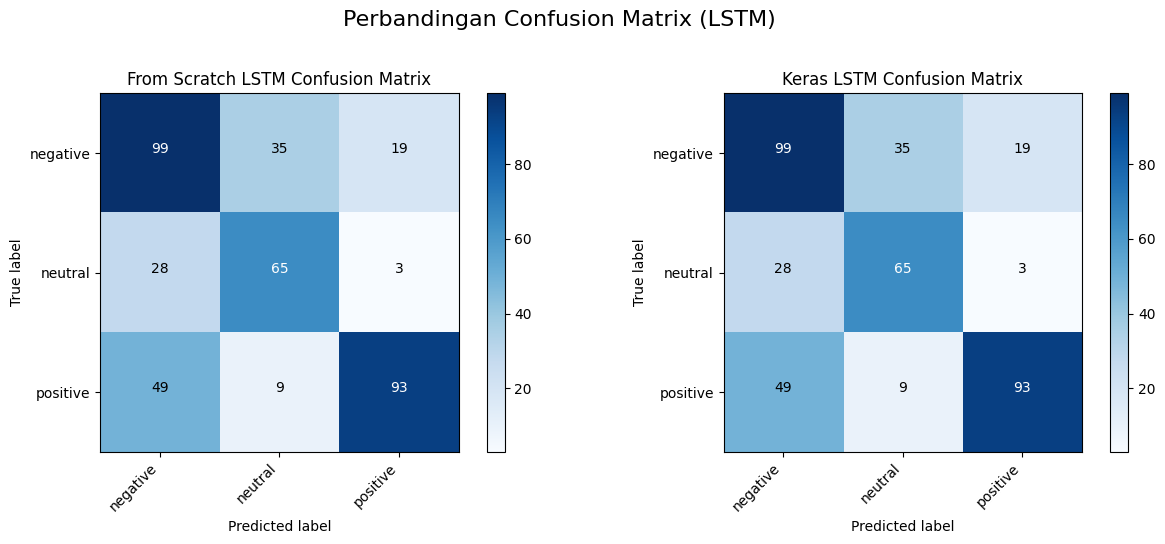

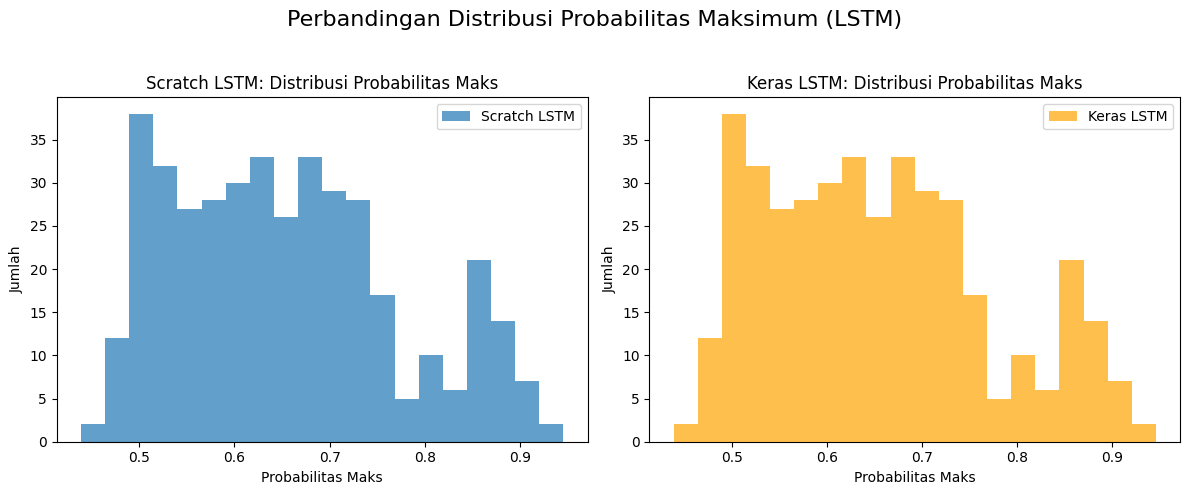

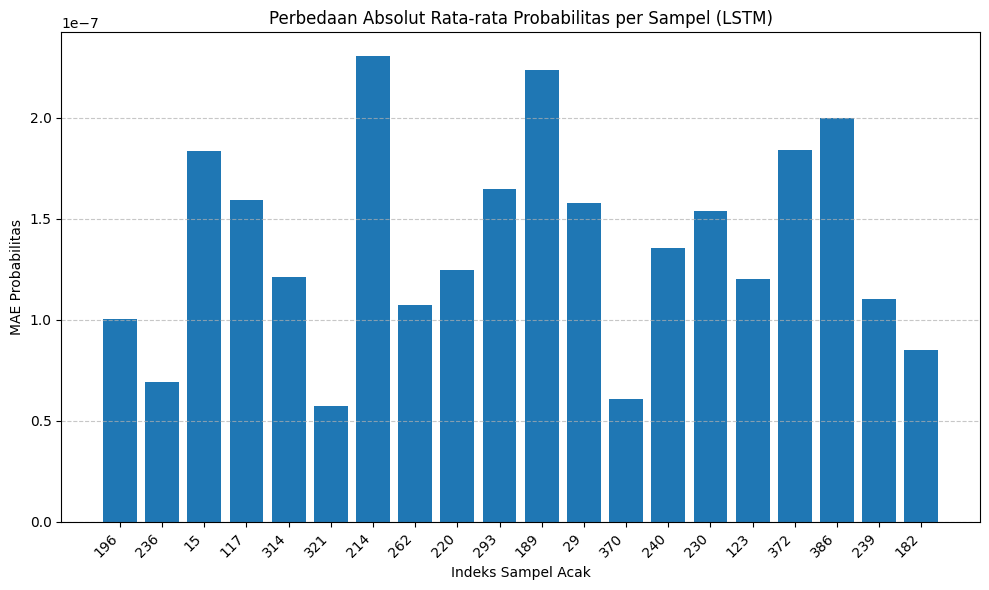

In [18]:
print("\n" + "="*60)
print("PERSIAPAN UJI FROM SCRATCH: 3 LAYER BIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l3_bi_exp = "lstm_layers_3" 

keras_model_path_l3_bi_exp = f"models/{model_name_l3_bi_exp}_full_model.keras"
vectorizer_path_l3_bi_exp = f"models/{model_name_l3_bi_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l3_bi_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l3_bi_exp}")

scratch_rnn_l3_bi_exp = run_lstm_from_scratch_comparison(keras_model_path_l3_bi_exp, vectorizer_path_l3_bi_exp)


PERSIAPAN UJI FROM SCRATCH: 2 LAYER UNIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN
Akan menggunakan model Keras dari: models/lstm_unidirectional_lstm_full_model.keras
Akan menggunakan vectorizer dari: models/lstm_unidirectional_lstm_vectorizer.keras

LSTM FROM SCRATCH IMPLEMENTATION COMPARISON (ROBUST)
Loaded test data: 400 samples
Loading Keras LSTM model from: models/lstm_unidirectional_lstm_full_model.keras
Loading vectorizer from: models/lstm_unidirectional_lstm_vectorizer.keras

Extracting weights from Keras LSTM model...
Processing layer: embedding_layer (Type: Embedding)
  Extracted embedding weights, shape: (2836, 128)
Processing layer: embedding_dropout (Type: SpatialDropout1D)
Processing layer: lstm_layer_1 (Type: LSTM)
  Extracted Unidirectional LSTM (lstm_layer_1) weights with prefix 'uni_lstm_1_'
Processing layer: dropout_lstm_1 (Type: Dropout)
Processing layer: lstm_layer_2 (Type: LSTM)
  Extracted Unidirectional LSTM (lstm_layer_2) weights with prefix 'un

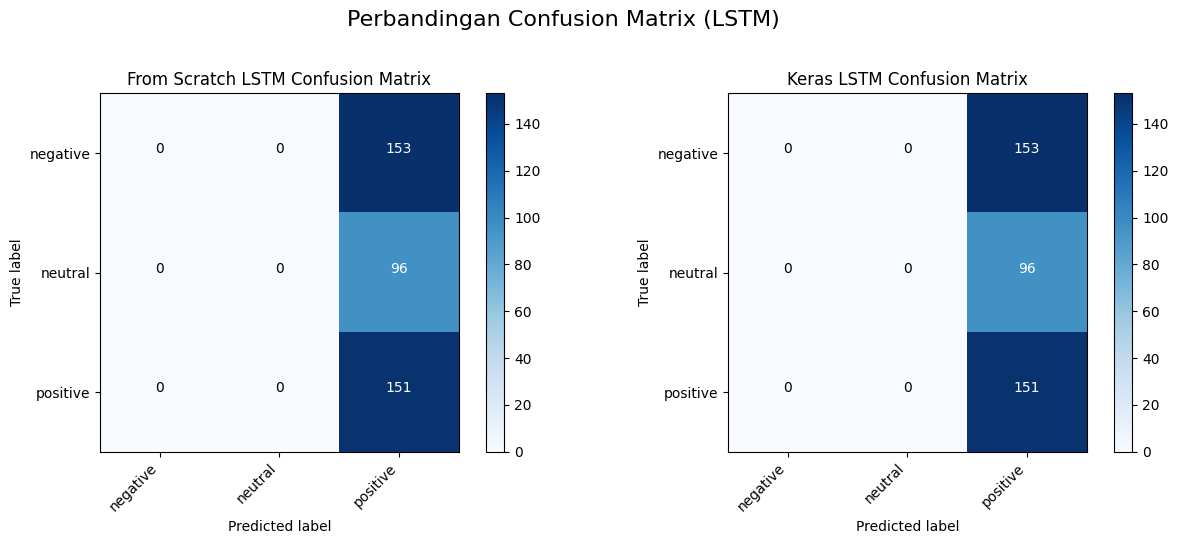

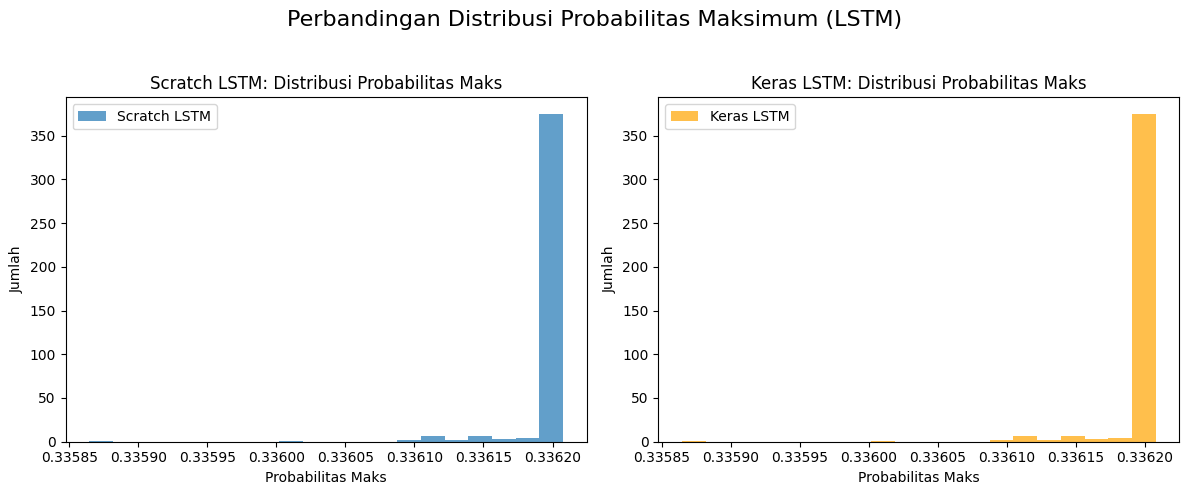

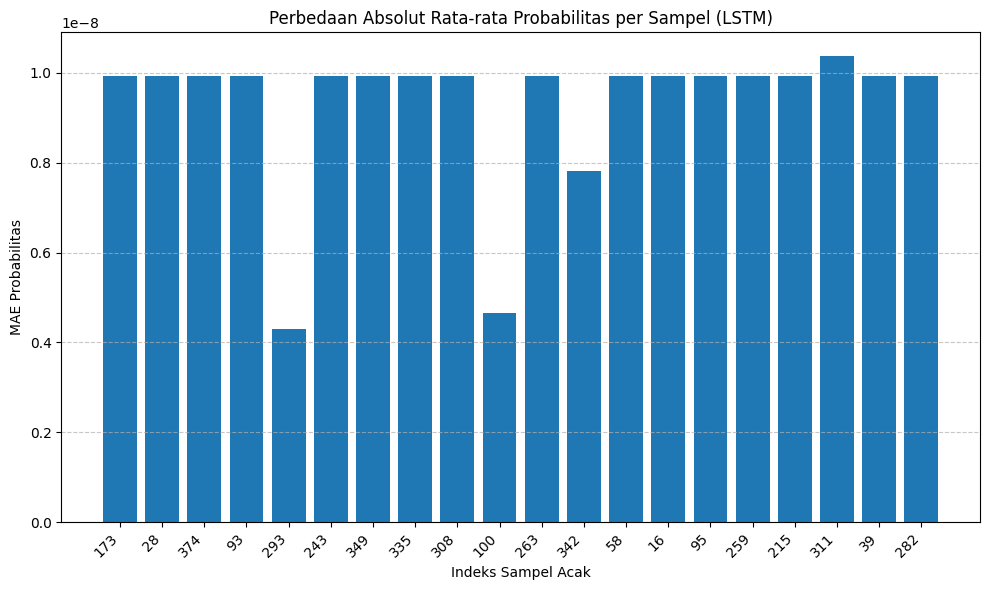

In [20]:
print("\n" + "="*60)
print("PERSIAPAN UJI FROM SCRATCH: 2 LAYER UNIDIRECTIONAL LSTM (u64) - MENGGUNAKAN MODEL DARI EKSPERIMEN")
print("="*60)

model_name_l2_uni_exp = "lstm_unidirectional_lstm" 

keras_model_path_l2_uni_exp = f"models/{model_name_l2_uni_exp}_full_model.keras"
vectorizer_path_l2_uni_exp = f"models/{model_name_l2_uni_exp}_vectorizer.keras"

print(f"Akan menggunakan model Keras dari: {keras_model_path_l2_uni_exp}")
print(f"Akan menggunakan vectorizer dari: {vectorizer_path_l2_uni_exp}")

scratch_rnn_l2_uni_exp = run_lstm_from_scratch_comparison(keras_model_path_l2_uni_exp, vectorizer_path_l2_uni_exp)